In [3]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
#from scipy import interpolate
from astropy.table import Table
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import scipy.optimize as op
import corner
import emcee
import src
from scipy.optimize import curve_fit
%matplotlib notebook

In [2]:
catalog = fits.open('Catalogs/age_calibrators_bayes.fits')

ewha = catalog[1].data['ewha']
ewha_error = catalog[1].data['ewha_error']
lewha = np.log10(ewha)
lewha_error = np.array([np.nanstd(np.log10(np.random.normal(ha_i,eha_i,2000))) for ha_i,eha_i in zip(ewha,ewha_error)])
age = catalog[1].data['age']
age_err_low = catalog[1].data['age_error_low']
age_err_high = catalog[1].data['age_error_high']
lage = np.log10(age)
ra = catalog[1].data['ra']
dec = catalog[1].data['dec']
ra_gaia = catalog[1].data['ra_gaia']
dec_gaia = catalog[1].data['dec_gaia']
g = catalog[1].data['g_corr']
rp = catalog[1].data['rp_corr']
g_snr = catalog[1].data['phot_g_mean_flux']/catalog[1].data['phot_g_mean_flux_error']
rp_snr = catalog[1].data['phot_rp_mean_flux']/catalog[1].data['phot_rp_mean_flux_error']
lhalbol = catalog[1].data['lhalbol']
lhalbol_err = catalog[1].data['lhalbol_error']
log_lhalbol = np.log10(lhalbol)
log_lhalbol_error = np.ones(len(lhalbol))*0.1
parallax = catalog[1].data['parallax']
g_abs = g - 5*(np.log10(1e3/parallax)-1)
source_id = catalog[1].data['gaia_source_id']
g_rp = g-rp
group_name = catalog[1].data['group_name']
group_num = catalog[1].data['group_num']

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log10


<IPython.core.display.Javascript object>


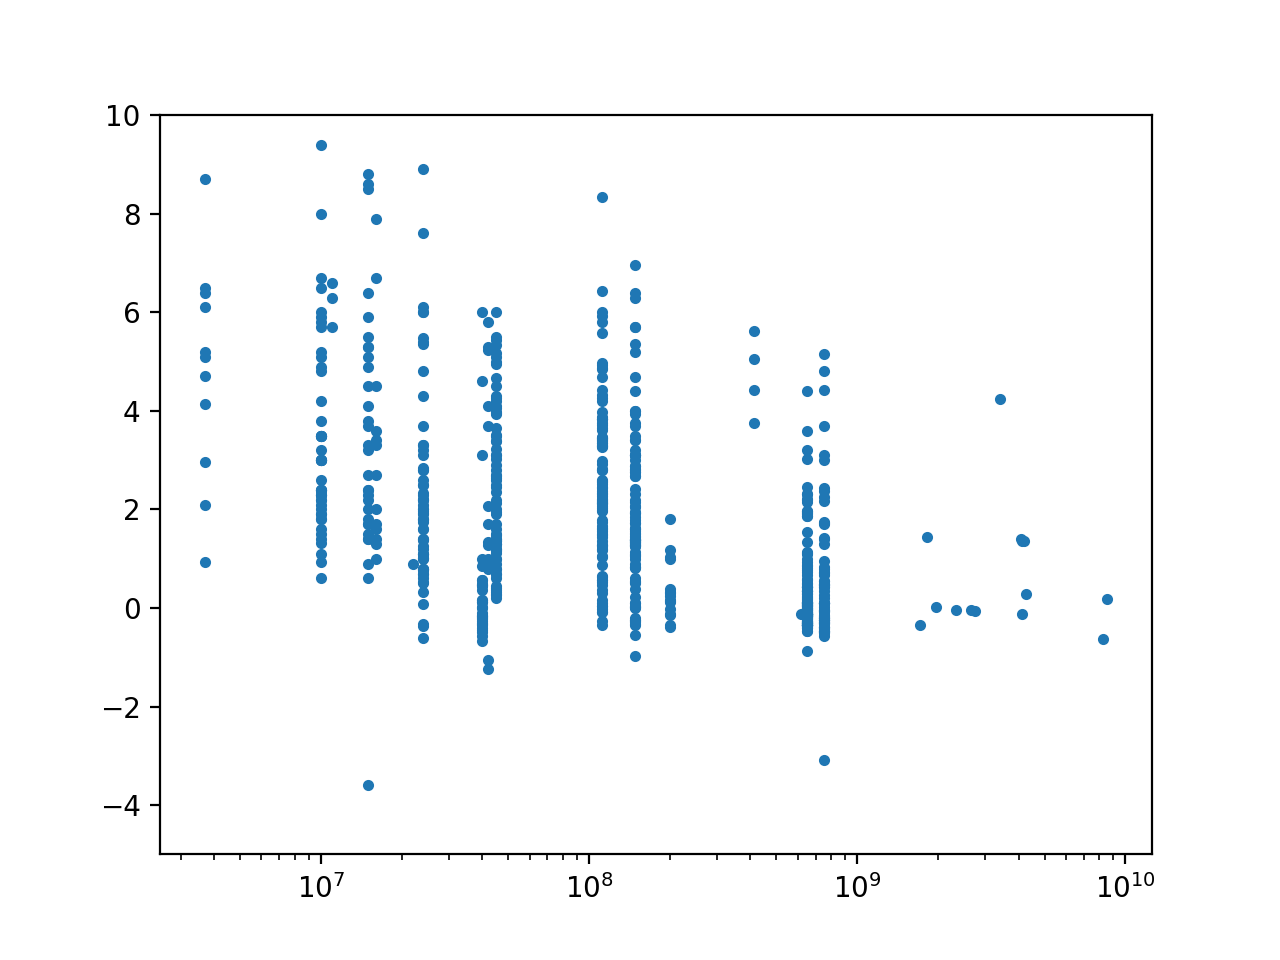

(-5, 10)

In [52]:
mask_color_1 = (0.8 <= g_rp) * (g_rp < 1.16)#Early Ms partialy convective
mask_color_2 = (1.16 <= g_rp) * (g_rp < 1.44)#Mid Ms fully convective
mask_color_3 = (1.44 <= g_rp) * (g_rp < 1.65)#Ultracool dwarfs 

plt.plot(age[mask_color_1],ewha[mask_color_1],'.')
plt.xscale('log')
plt.ylim(-5,10)

<IPython.core.display.Javascript object>


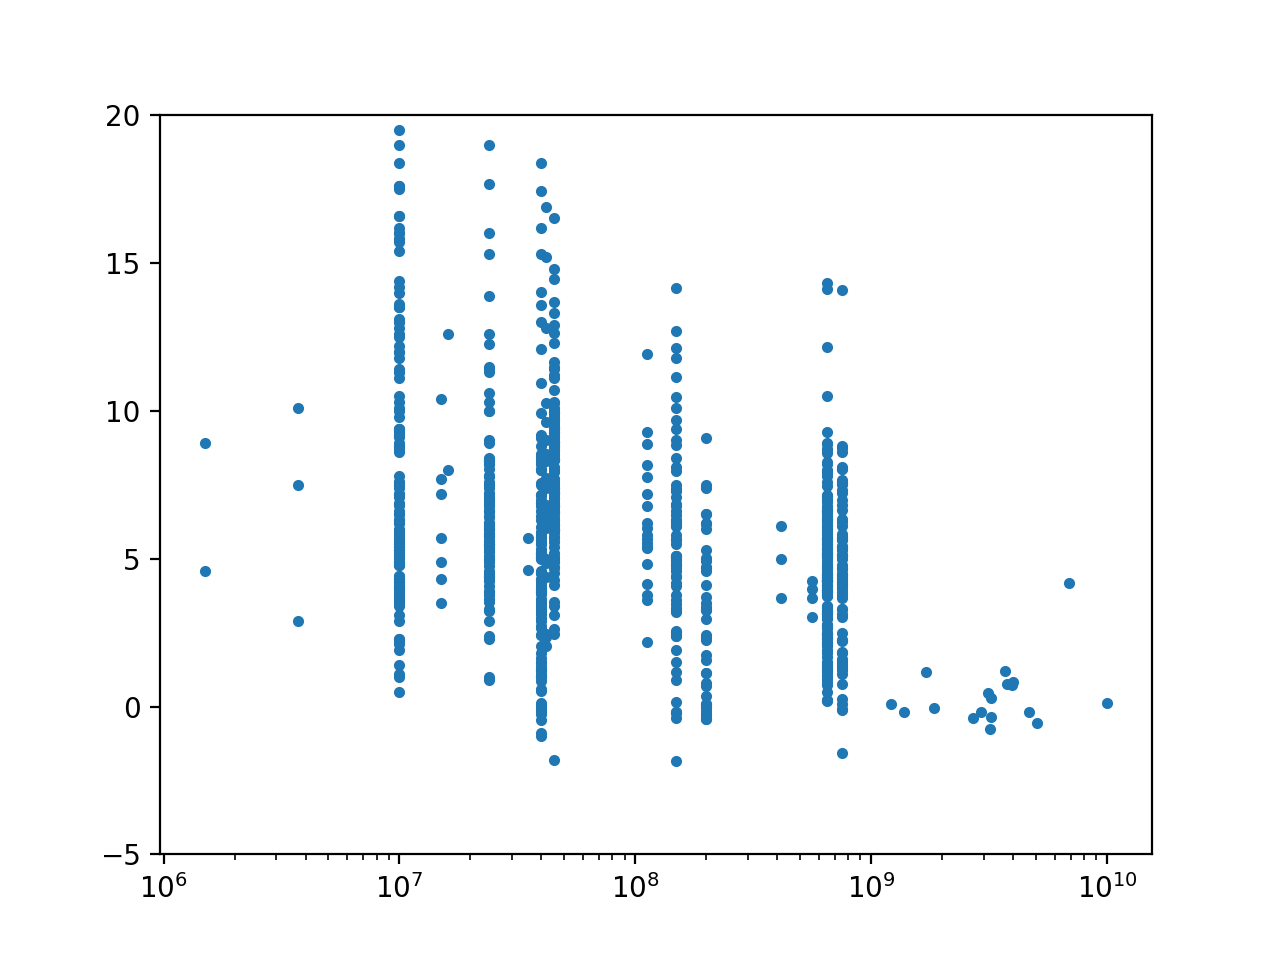

(-5, 20)

In [53]:
plt.plot(age[mask_color_2],ewha[mask_color_2],'.')
plt.xscale('log')
plt.ylim(-5,20)

<IPython.core.display.Javascript object>


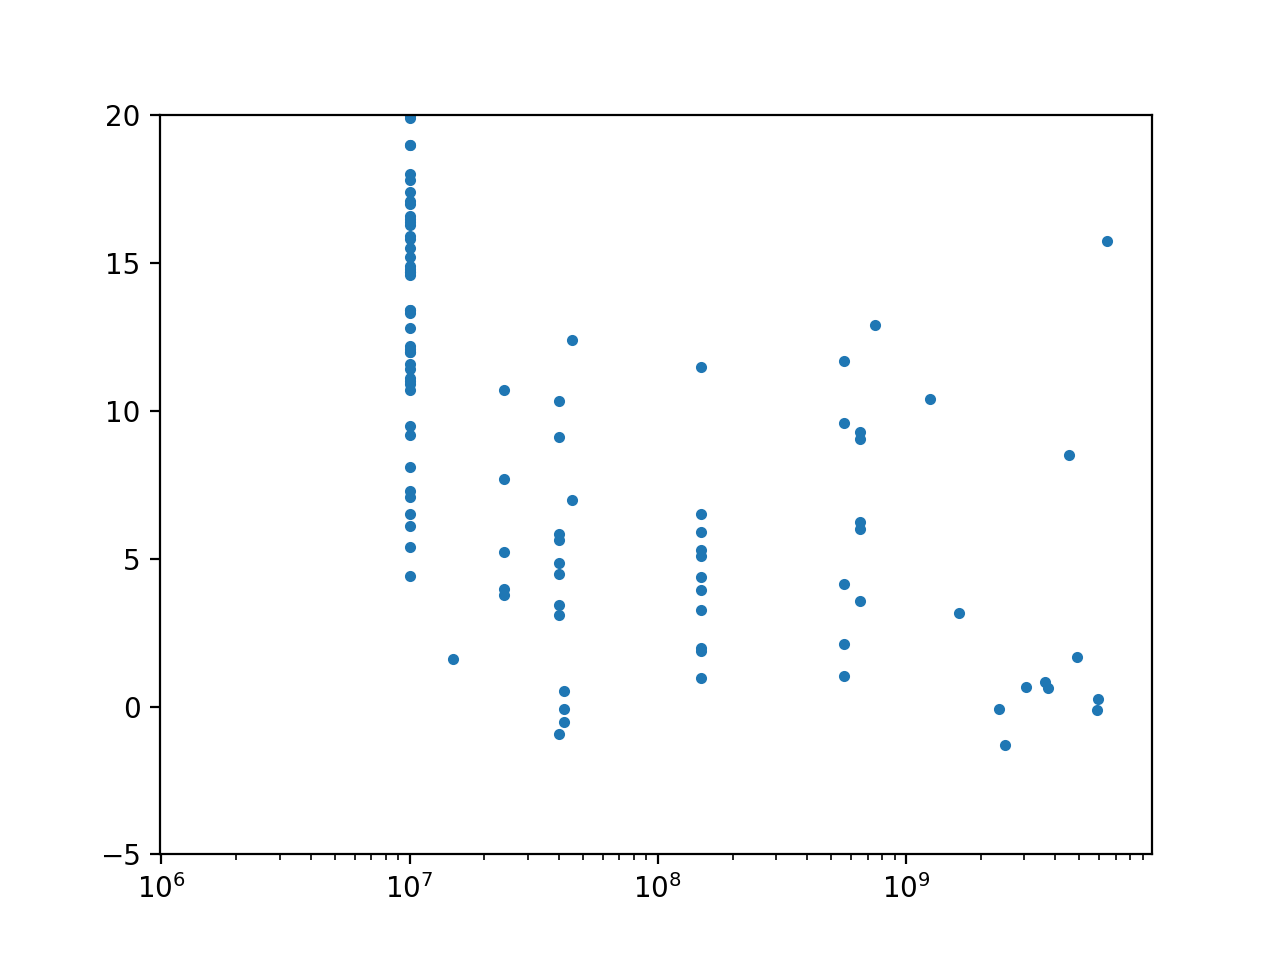

(-5, 20)

In [51]:
plt.plot(age[mask_color_3],ewha[mask_color_3],'.')
plt.xscale('log')
plt.ylim(-5,20)

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """


<IPython.core.display.Javascript object>


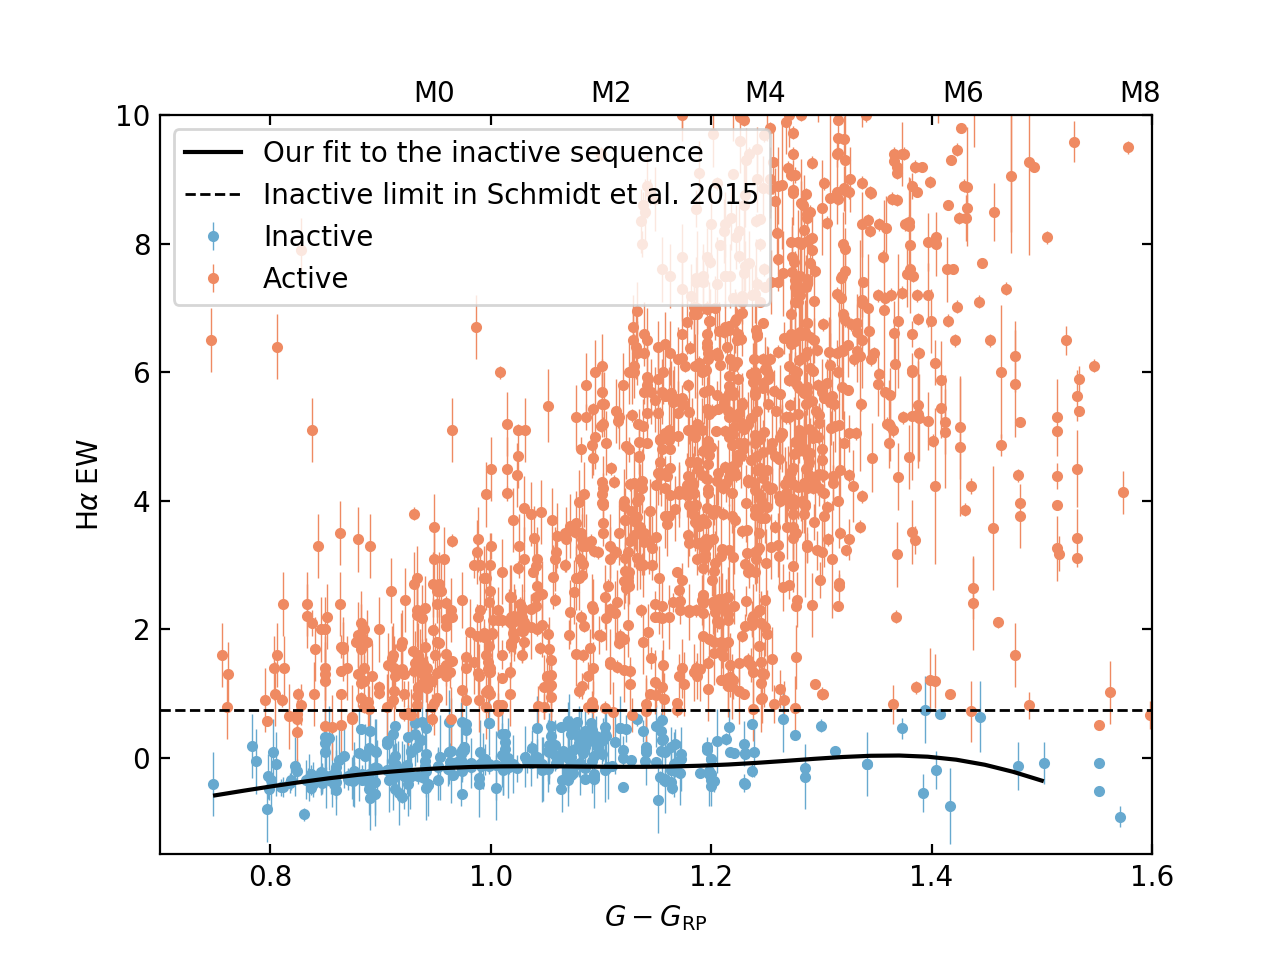

In [17]:
path = '/Users/rociokiman/Dropbox (Personal)/Apps/Overleaf/Age-Activity Relation for M dwarfs/'
p_inactive = np.array([395.50786613,-3045.0560077,9964.56950987,-18068.29454717,19816.23461458,
                       -13428.70983305,5469.77129071,-1212.66808967,108.51204825])
mask_inactive = abs(np.polyval(p_inactive,g_rp)-ewha) < 0.75
mask_active = ewha - np.polyval(p_inactive,g_rp) >= 0.75
mask_late_type = g_rp > 1.4
lw = .5
y_text=10.2

x = np.linspace(0.75,1.5,30)
plt.errorbar(g_rp[mask_inactive],ewha[mask_inactive],yerr=ewha_error[mask_inactive],label='Inactive',
             fmt='.',elinewidth=lw,zorder=0,color='#67a9cf')
plt.errorbar(g_rp[mask_active],ewha[mask_active],yerr=ewha_error[mask_active],label='Active',
             fmt='.',elinewidth=lw,zorder=0,color='#ef8a62')
plt.plot(x,np.polyval(p_inactive,x),'-k',zorder=2,label='Our fit to the inactive sequence')
plt.axhline(y=0.75,color='k',linestyle='--',linewidth=1,label='Inactive limit in Schmidt et al. 2015',zorder=2)
plt.legend(loc=2)
plt.tick_params('both',direction='in',top=True,right=True)
plt.tick_params('both',which='minor',direction='in',top=True,right=True)
plt.xlabel(r'$G-G_{\rm RP}$')
plt.ylabel(r'${\rm H}\alpha \; {\rm EW}$')
plt.xlim(0.7,1.6)
plt.ylim(-1.5,10)
plt.text(0.93,y_text,'M0')
plt.text(1.09,y_text,'M2')
plt.text(1.23,y_text,'M4')
plt.text(1.41,y_text,'M6')
plt.text(1.57,y_text,'M8')
plt.savefig(path+'inactive_sequence.png',dpi=300,tight_layout=True)

In [18]:
ra_weird = [279.9099730555555,279.90995833,279.909973,208.74074035]
dec_weird = [16.387083055555554,16.38711111,16.387083,5.21089823]
mask_weird = np.array([True if(any(np.isclose(ra_i,ra_weird)) and any(np.isclose(dec_i,dec_weird))) else False for
                 ra_i,dec_i in zip(ra,dec)])

In [19]:
mask_keep =  ((ewha/ewha_error>3) * (~np.isnan(ewha_error)) * (rp_snr > 10) * (g_rp > 0.8) 
               * (group_num!=2) * (~mask_weird))


/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


<IPython.core.display.Javascript object>


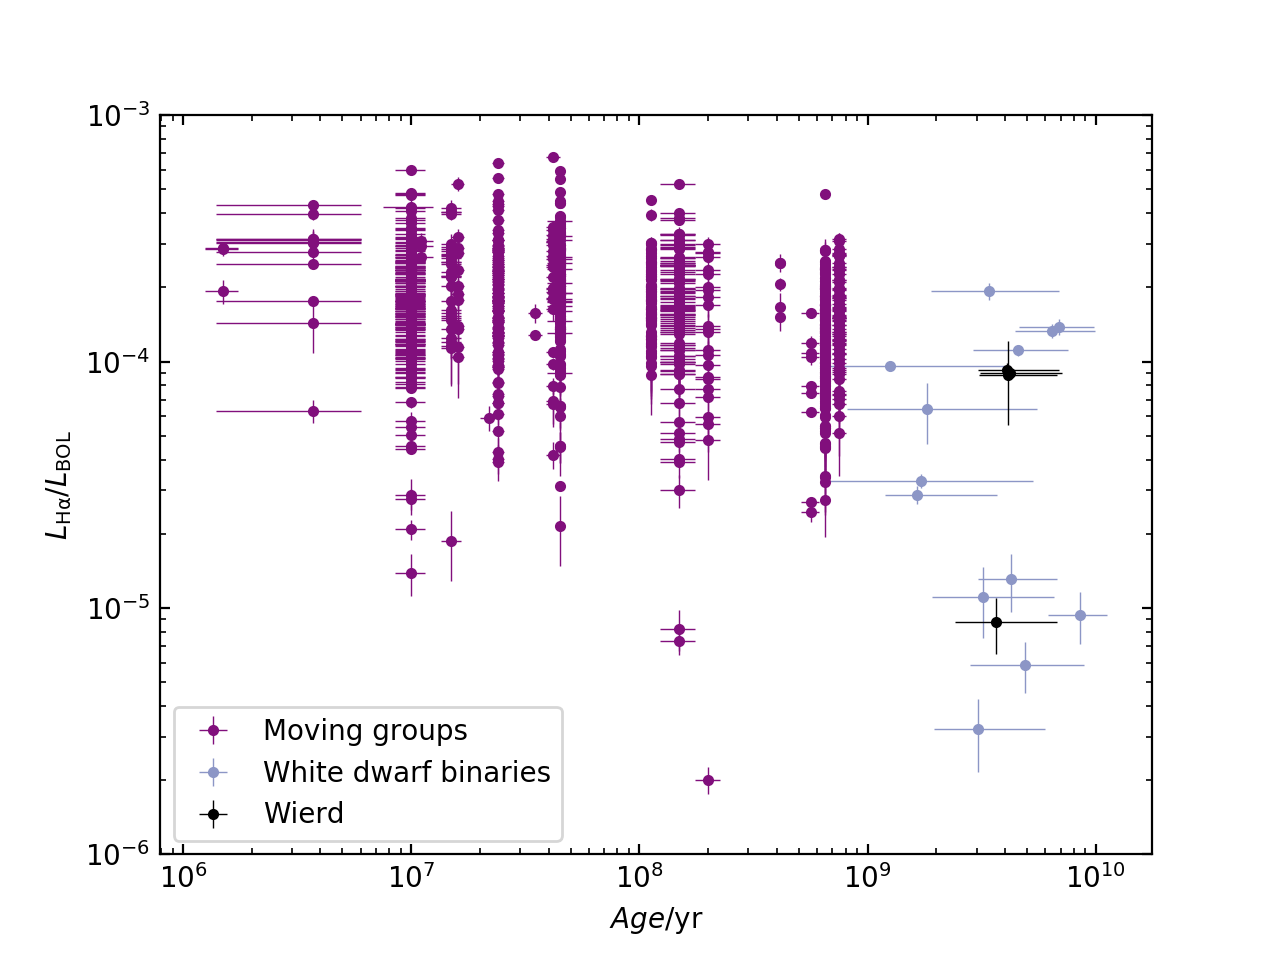

In [28]:
mask_binaries = group_num==0
vmin = 0.8
vmax = 1.6
path = '/Users/rociokiman/Dropbox (Personal)/Apps/Overleaf/Age-Activity Relation for M dwarfs/'
x = np.linspace(-1,10,2000)
#idx_simple = np.random.randint(len(flat_samples_simple[:,0]), size=100)

plt.errorbar(age[mask_keep*~mask_binaries],
             lhalbol[mask_keep*~mask_binaries],
             xerr=(age_err_low[mask_keep*~mask_binaries],age_err_high[mask_keep*~mask_binaries]),
             yerr = lhalbol_err[mask_keep*~mask_binaries],
             label='Moving groups',fmt='.',elinewidth=.5,color='#810f7c',zorder=0)
plt.errorbar(age[mask_keep*mask_binaries],
             lhalbol[mask_keep*mask_binaries],
             xerr=(age_err_low[mask_keep*mask_binaries],age_err_high[mask_keep*mask_binaries]),
             yerr = lhalbol_err[mask_keep*mask_binaries],
             label='White dwarf binaries',fmt='.',elinewidth=0.5,color='#8c96c6',zorder=0)
plt.errorbar(age[mask_weird],lhalbol[mask_weird],
             xerr=(age_err_low[mask_weird],age_err_high[mask_weird]),
             yerr = lhalbol_err[mask_weird],
             fmt='.',color='k',elinewidth=.5,zorder=3,label='Wierd')
plt.xlabel(r'$Age/$yr')
plt.ylabel(r'$L_{\rm H\alpha}/L_{\rm BOL}$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-6,1e-3)
plt.tick_params('both',direction='in',top=True,right=True)
plt.tick_params('both',which='minor',direction='in',top=True,right=True)
plt.legend()
plt.savefig(path+'ageactivity.png',dpi=300)
plt.show()


In [29]:
def linear_model(x,a,b):
    return a*x+b

def polynomial(x,*p):
    return np.polyval(p,x)

def broken_power_law(x,*p):
    a0,a1,a2,a3 = p
    if(isinstance(x, float)):
        if(x<a0):
            y_model = a1*x + a2
        else:
            y_model = a3*x + (a1-a3)*a0 + a2 
    else:
        y_model = np.ones(len(x))*np.nan
        mask = x < a0
        y_model[mask] = a1*x[mask] + a2
        y_model[~mask] = a3*x[~mask] + (a1-a3)*a0 + a2 
    return y_model

In [30]:
mask_good = (~np.isnan(g_rp+lage+log_lhalbol+log_lhalbol_error) * mask_keep
             * (log_lhalbol_error!=0) )

In [31]:
scores = []
for n in range(2,8):
    ini_params = np.ones(n)
    scores.append(src.calc_cross_validation(lage[mask_good],log_lhalbol[mask_good],
                                            log_lhalbol_error[mask_good],polynomial,ini_params))

In [32]:
ini_params = np.array([9,-.1,1,-4])
score_broken = src.calc_cross_validation(lage[mask_good],log_lhalbol[mask_good],
                                         log_lhalbol_error[mask_good],broken_power_law,ini_params)

<IPython.core.display.Javascript object>


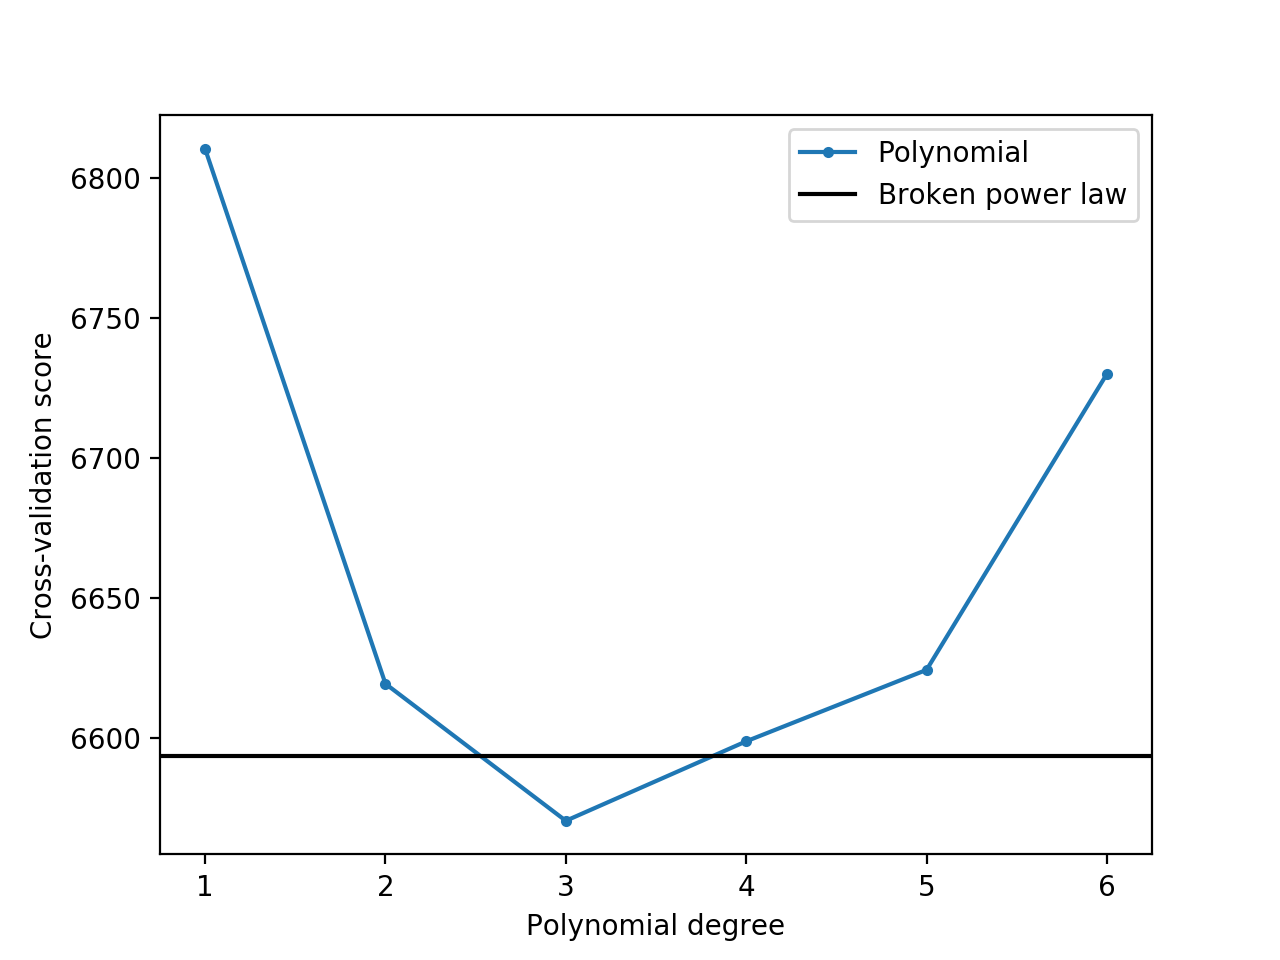

In [33]:
plt.plot(np.arange(2,8)-1,scores,'.-',label='Polynomial')
plt.axhline(y=score_broken,color='k',label='Broken power law')
plt.ylabel('Cross-validation score')
plt.xlabel('Polynomial degree')
plt.legend()

In [34]:
ini_params = np.ones(4)
popt,pcov=curve_fit(polynomial,lage[mask_good],log_lhalbol[mask_good],
                    p0=ini_params,sigma=log_lhalbol_error[mask_good])

ini_params = np.ones(2)
popt_linear,pcov=curve_fit(polynomial,lage[mask_good],log_lhalbol[mask_good],
                    p0=ini_params,sigma=log_lhalbol_error[mask_good])

ini_params = np.array([9,-.1,1,-4])
popt_broken,pcov=curve_fit(broken_power_law,lage[mask_good],log_lhalbol[mask_good],
                    p0=ini_params,sigma=log_lhalbol_error[mask_good])

In [35]:
mask_weird = (lage > 9) * (log_lhalbol > -4.1)

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


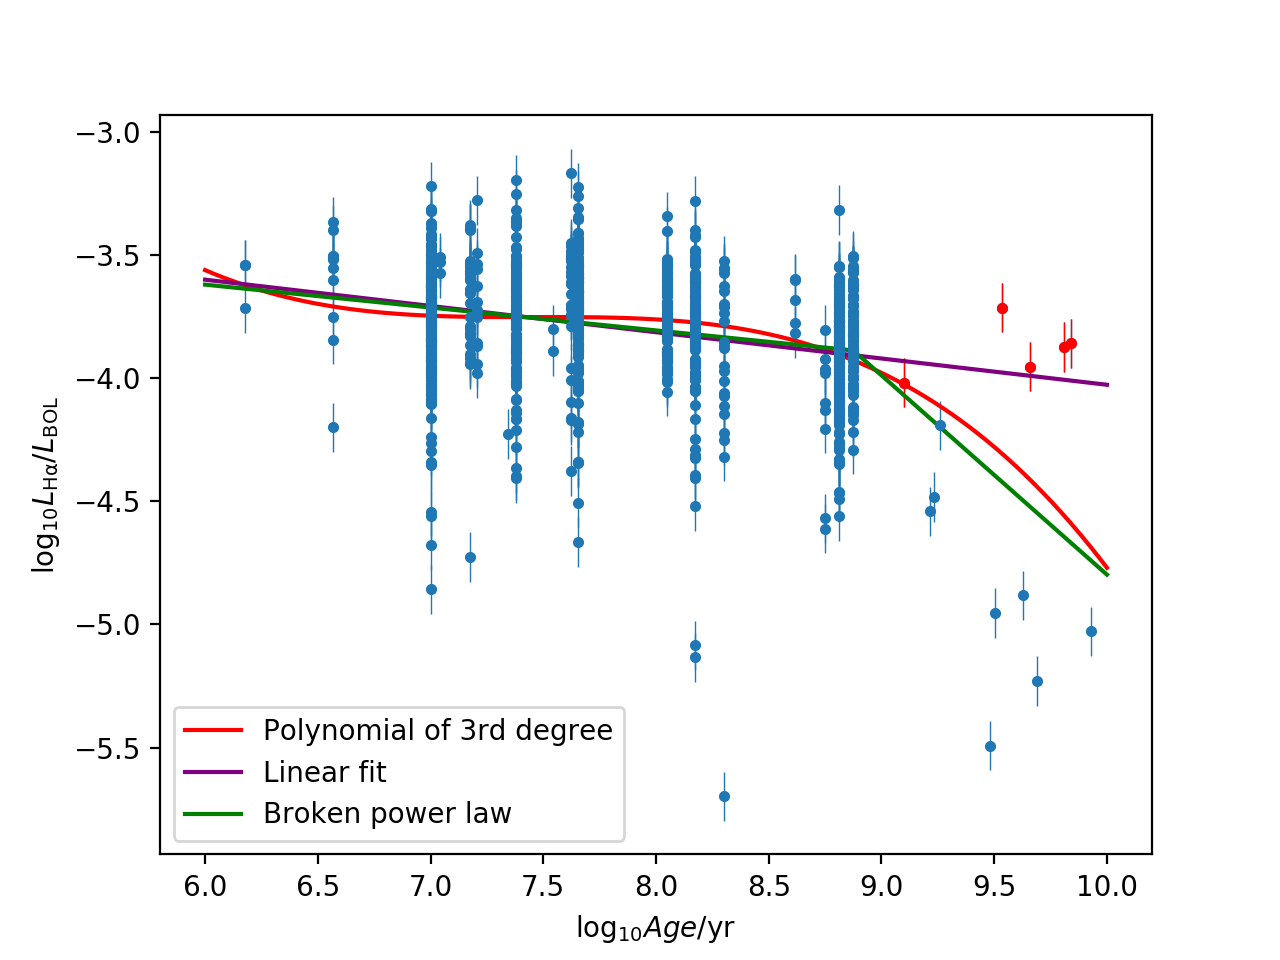

In [36]:
x=np.linspace(6,10,100)
plt.errorbar(lage[mask_good],log_lhalbol[mask_good],yerr=log_lhalbol_error[mask_good],
             fmt='.',elinewidth=.5)
plt.errorbar(lage[mask_good*mask_weird],log_lhalbol[mask_good*mask_weird],
             yerr=log_lhalbol_error[mask_good*mask_weird],
             fmt='r.',elinewidth=.5)
plt.plot(x,np.polyval(popt,x),color='r',label='Polynomial of 3rd degree')
plt.plot(x,np.polyval(popt_linear,x),color='purple',label='Linear fit')
plt.plot(x,broken_power_law(x,*popt_broken),color='g',label='Broken power law')
plt.xlabel(r'$\log _{10}Age/$yr')
plt.ylabel(r'$\log _{10}L_{\rm H\alpha}/L_{\rm BOL}$')
plt.legend()

In [37]:
for x,y,z in zip(ra[mask_good*mask_weird],dec[mask_good*mask_weird],source_id[mask_good*mask_weird]):
    print(z,x,y)

664326368611568128 129.83511945 20.02695525
4030722598505336192 177.21313443 32.89288385
1206777577001184128 240.52489566 23.36461347
1323975659572526976 241.98748932 34.97270594
1328907068007155072 244.31911926 34.38518982


<IPython.core.display.Javascript object>


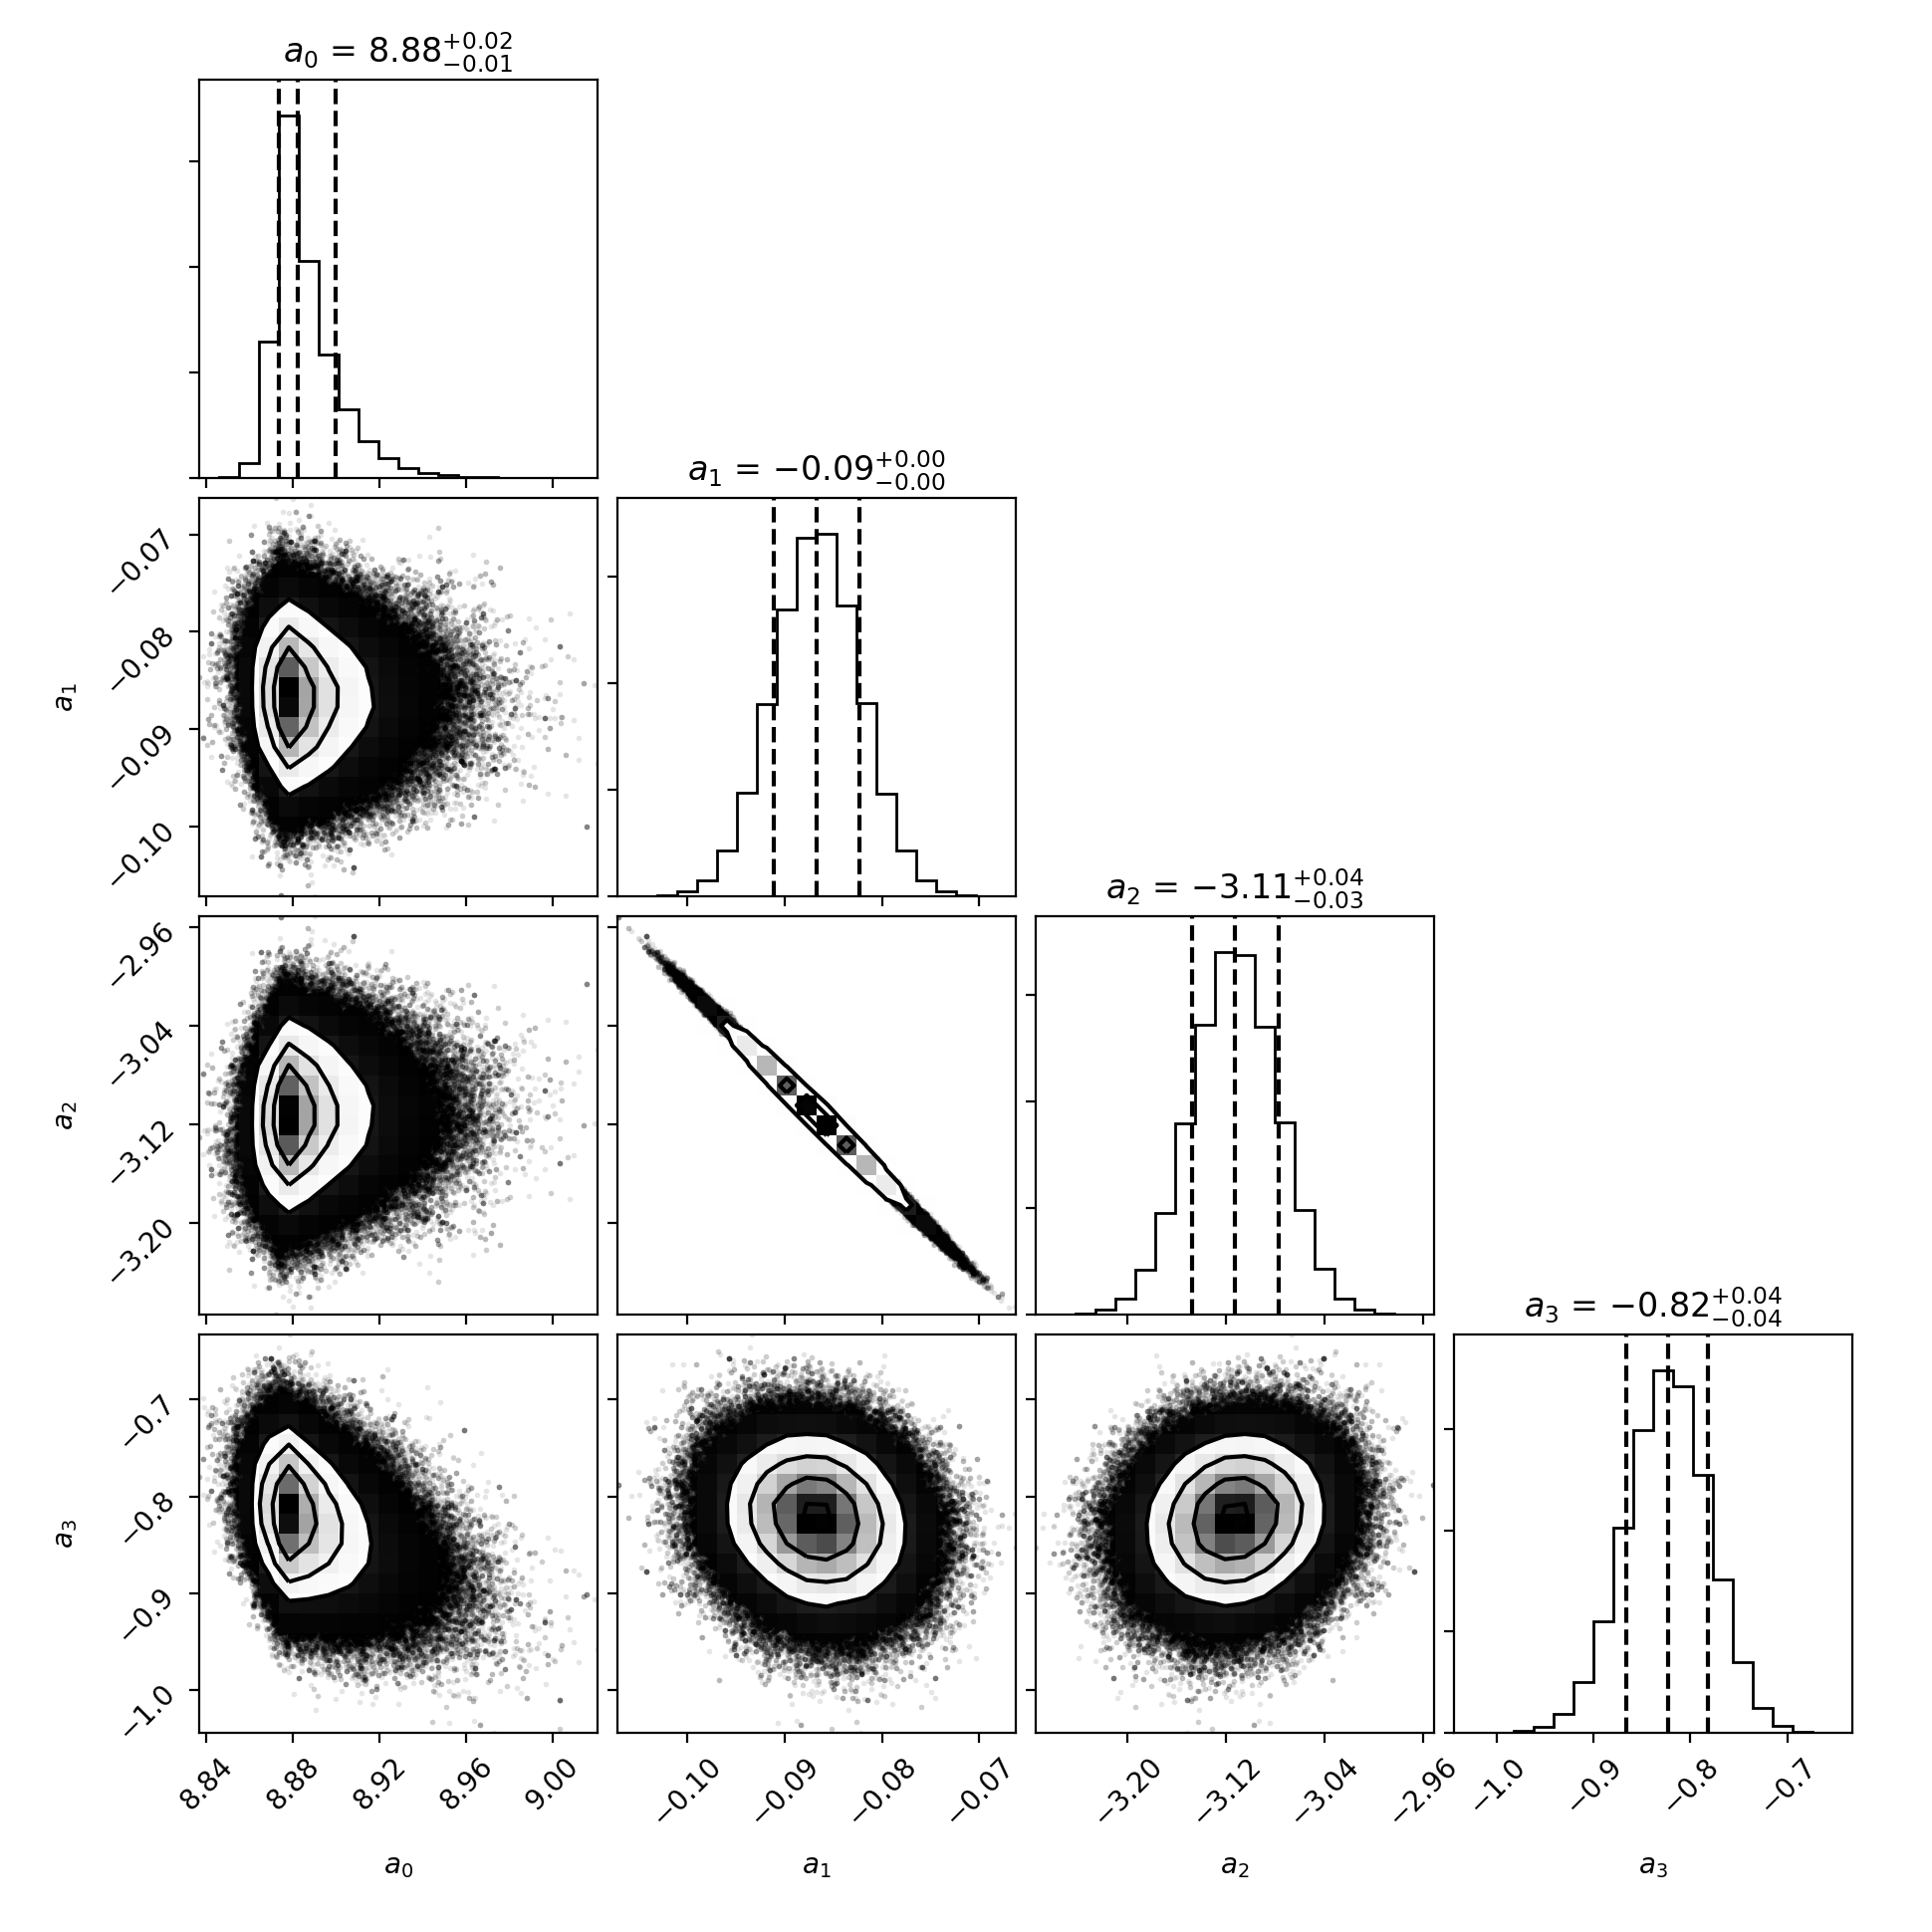

In [38]:
mask_good = (~np.isnan(g_rp+lage+log_lhalbol+log_lhalbol_error) * mask_keep
             * (log_lhalbol_error!=0) )
chain_simple,flat_samples_simple = src.fit_relation_simple_func(mask_good,lage,log_lhalbol,log_lhalbol_error,
                                             name='corner_fit_simple.png')

<IPython.core.display.Javascript object>


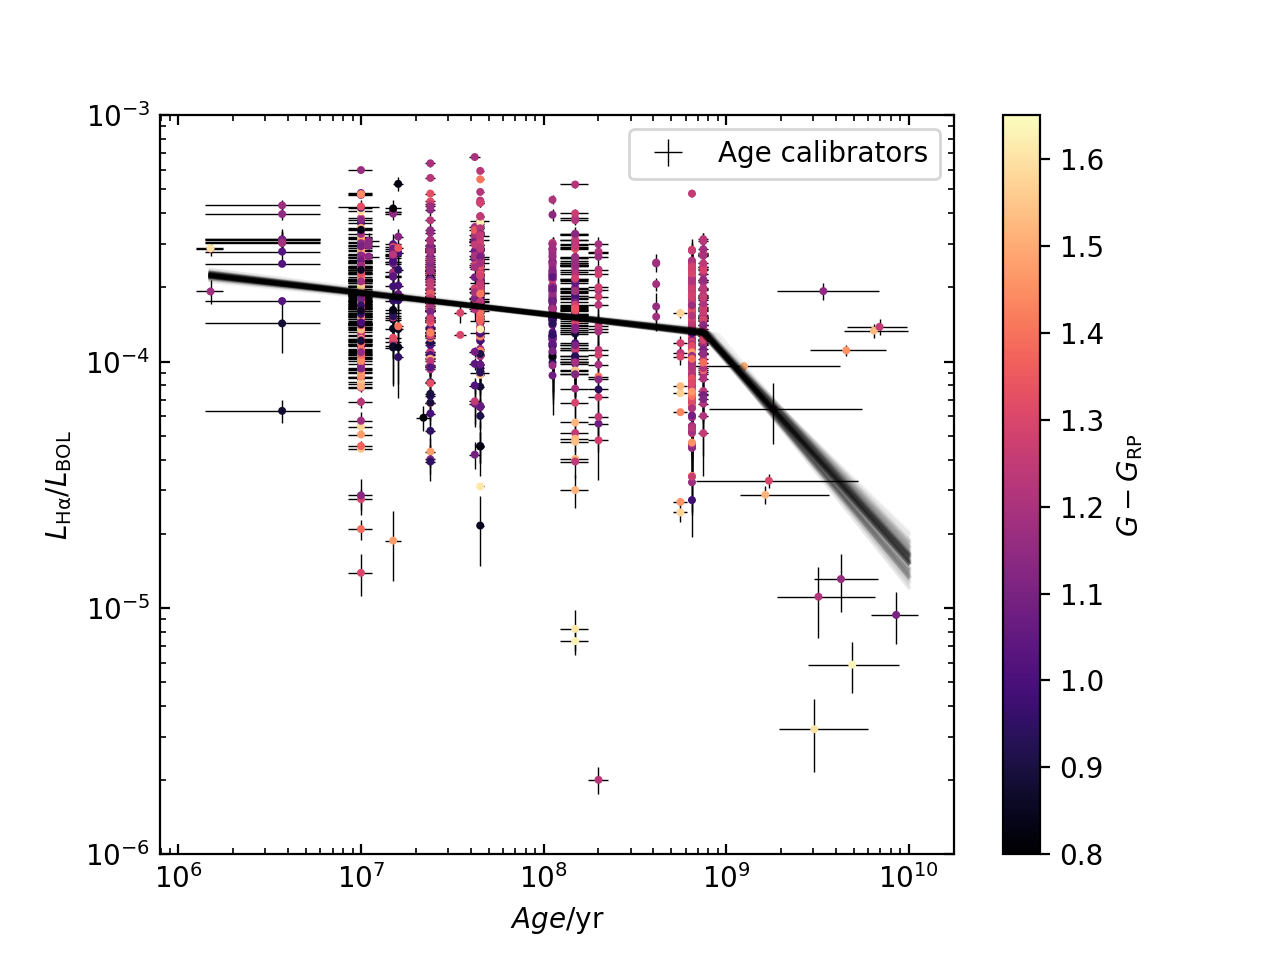

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10
/Users/rociokiman/Documents/M-dwarfs-Age-Activity-Relation/src/fit_age_activity_relation.py:71: RuntimeWarning: invalid value encountered in less
  mask = log_age < a0


In [39]:
mask_binaries = group_num==0
vmin = 0.8
vmax = 1.6
path = '/Users/rociokiman/Dropbox (Personal)/Apps/Overleaf/Age-Activity Relation for M dwarfs/'
x = np.linspace(-1,10,2000)
idx_simple = np.random.randint(len(flat_samples_simple[:,0]), size=100)

plt.errorbar(age[mask_keep],
             lhalbol[mask_keep],
             xerr=(age_err_low[mask_keep],age_err_high[mask_keep]),
             yerr = lhalbol_err[mask_keep],
             label='Age calibrators',elinewidth=.5,color='k',zorder=0,fmt='none')
plt.scatter(age[mask_keep],lhalbol[mask_keep],c=g_rp[mask_keep],s=3.5,zorder=2,cmap='magma',
            vmin = 0.8,vmax = 1.65)

for idx_j in idx_simple:
    plt.plot(x*1e9,10**src.fit_halpha_simple(flat_samples_simple[idx_j,:],np.log10(x*1e9)),
             color='k',alpha=0.05,zorder=3)
#plt.colorbar(label=r'$G-G_{\rm RP}$')
plt.xlabel(r'$Age/$yr')
plt.ylabel(r'$L_{\rm H\alpha}/L_{\rm BOL}$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-6,1e-3)
plt.tick_params('both',direction='in',top=True,right=True)
plt.tick_params('both',which='minor',direction='in',top=True,right=True)
plt.legend()
plt.colorbar(label=r'$G-G_{\rm RP}$')
plt.savefig(path+'ageactivity_fit.png',dpi=300)
plt.show()


In [40]:
mask_color_1 = (0.8 <= g_rp) * (g_rp < 1.13)#Early Ms partialy convective
mask_color_2 = (1.13 <= g_rp) * (g_rp < 1.44)#Mid Ms fully convective
mask_color_3 = (1.44 <= g_rp) * (g_rp < 1.65)#Ultracool dwarfs 

mask_good = (~np.isnan(g_rp+lage+log_lhalbol+log_lhalbol_error) * mask_keep
             * (log_lhalbol_error!=0) * (~mask_weird))

<IPython.core.display.Javascript object>


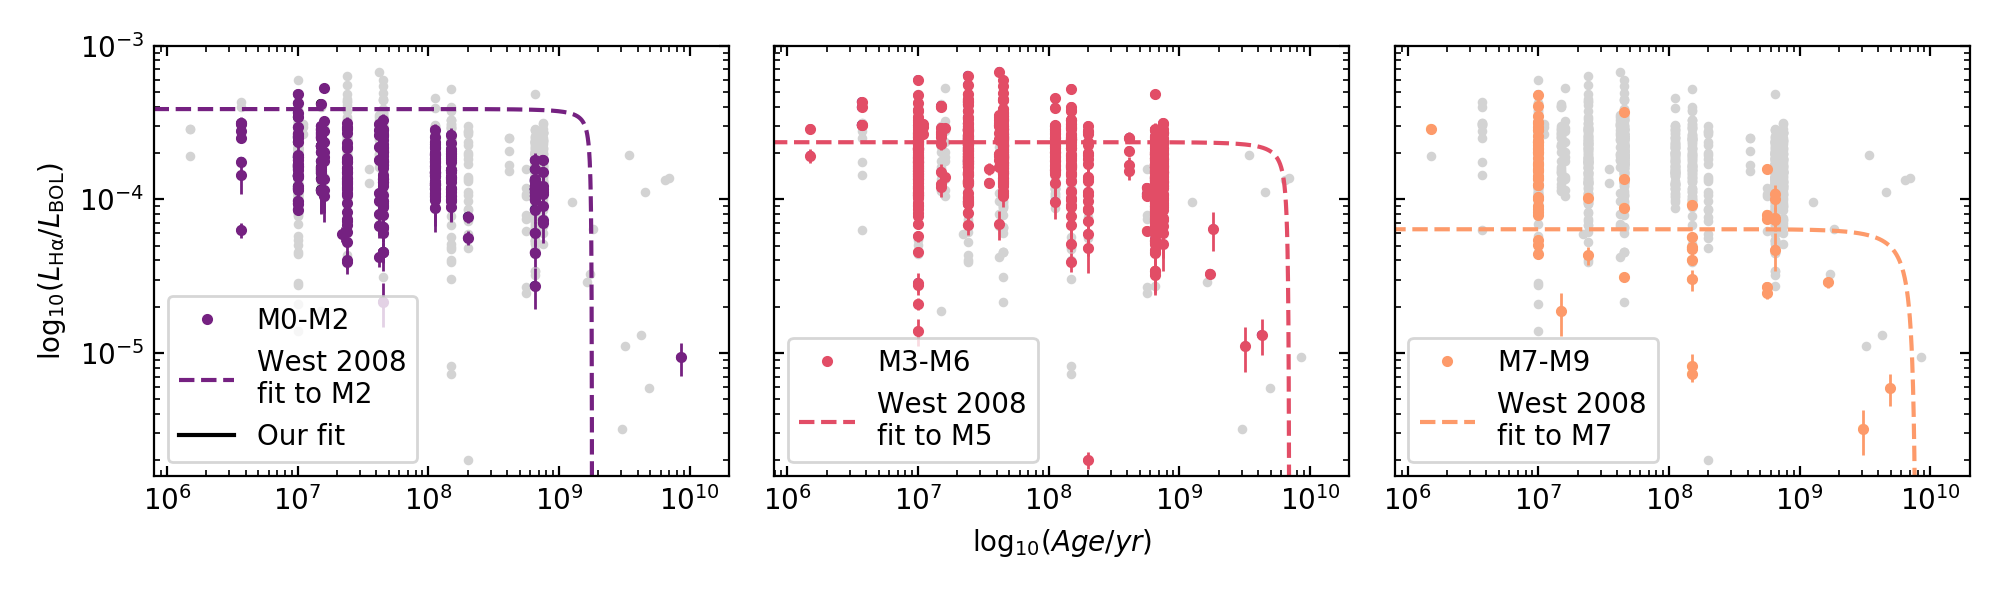

In [41]:
vmin = 0.8
vmax = 1.65
s=6
lw=1

cmap = cm.magma
norm = Normalize(vmin=vmin, vmax=vmax)

color1 = cmap(norm(1.09)) #M2
color2 = cmap(norm(1.32)) #M5
color3 = cmap(norm(1.47)) #M7

x = np.linspace(-10,9,2000)

#idx_color_1 = np.random.randint(len(flat_samples1[:,0]), size=100)
#idx_color_2 = np.random.randint(len(flat_samples2[:,0]), size=100)
#idx_color_3 = np.random.randint(len(flat_samples3[:,0]), size=100)

f, (ax1,ax2,ax3) = plt.subplots(1,3,sharex=True,sharey=True,figsize=(10,3))

ax1.scatter(age[mask_keep],lhalbol[mask_keep],s=s,color='lightgrey')
ax1.scatter(age[mask_good * mask_color_1],lhalbol[mask_good * mask_color_1],
            c=g_rp[mask_good * mask_color_1],
            vmin=vmin,vmax=vmax,cmap='magma',s=s)
ax1.errorbar(age[mask_good * mask_color_1],lhalbol[mask_good * mask_color_1],
             yerr=lhalbol_err[mask_good * mask_color_1],elinewidth=lw,color=color1,fmt='.')
ax1.plot([0,0],[0,0],'.',color=color1,label='M0-M2')
ax1.plot(x*1e9,10**src.west2008(x,0.106,3.38,2.0,1.8),
         color=color1,linestyle='--',label='West 2008\nfit to M2')
#for idx_j in idx_color_1:
#    ax1.plot(np.log10(x*1e9),src.fit_halpha(flat_samples1[idx_j,:],1.09,np.log10(x*1e9)),color=color1,alpha=0.05)
#ax1.plot([0,0],[0,0],'-',color=color1,label='Our fit to M0-M2') 
#for idx_j in idx_simple:
#    ax1.plot(x*1e9,10**src.fit_halpha_simple(flat_samples_simple[idx_j,:],np.log10(x*1e9)),
#             color='k',alpha=0.05,zorder=3)
ax1.plot([0,0],[0,0],'-',color='k',label='Our fit') 
ax1.legend(loc=3)
    
ax2.scatter(age[mask_keep],lhalbol[mask_keep],s=s,color='lightgrey')
ax2.scatter(age[mask_good * mask_color_2],lhalbol[mask_good * mask_color_2],
            c=g_rp[mask_good * mask_color_2],
            vmin=vmin,vmax=vmax,cmap='magma',s=s)
ax2.errorbar(age[mask_good * mask_color_2],lhalbol[mask_good * mask_color_2],
             yerr=lhalbol_err[mask_good * mask_color_2],elinewidth=lw,color=color2,fmt='.')
ax2.plot([0,0],[0,0],'.',color=color2,label='M3-M6')
ax2.plot(x*1e9,10**src.west2008(x,2.85,3.57,2.0,7.0),
         color=color2,linestyle='--',label='West 2008\nfit to M5')
#for idx_j in idx_color_2:
#    ax2.plot(np.log10(x*1e9),src.fit_halpha(flat_samples2[idx_j,:],1.32,np.log10(x*1e9)),color=color2,alpha=0.05)
#ax2.plot([0,0],[0,0],'-',color=color2,label='Our fit to M3-M6')    
#for idx_j in idx_simple:
#    ax2.plot(x*1e9,10**src.fit_halpha_simple(flat_samples_simple[idx_j,:],np.log10(x*1e9)),
#             color='k',alpha=0.05,zorder=3)
ax2.legend(loc=3)

ax3.scatter(age[mask_keep],lhalbol[mask_keep],s=s,color='lightgrey')
ax3.scatter(age[mask_good * mask_color_3],lhalbol[mask_good * mask_color_3],
            c=g_rp[mask_good * mask_color_3],
            vmin=vmin,vmax=vmax,cmap='magma',s=s)
ax3.errorbar(age[mask_good * mask_color_3],lhalbol[mask_good * mask_color_3],
             yerr=lhalbol_err[mask_good * mask_color_3],elinewidth=lw,color=color3,fmt='.')
ax3.plot([0,0],[0,0],'.',color=color3,label='M7-M9')
ax3.plot(x*1e9,10**src.west2008(x,11.8,4.01,2.0,8.0),
         color=color3,linestyle='--',label='West 2008\nfit to M7')
#for idx_j in idx_color_3:
#    ax3.plot(np.log10(x*1e9),src.fit_halpha(flat_samples3[idx_j,:],1.47,np.log10(x*1e9)),color=color3,alpha=0.05)
#ax3.plot([0,0],[0,0],'-',color=color3,label='Our fit to M7-M9')    
#for idx_j in idx_simple:
#    ax3.plot(x*1e9,10**src.fit_halpha_simple(flat_samples_simple[idx_j,:],np.log10(x*1e9)),
#             color='k',alpha=0.05,zorder=3)
ax3.legend(loc=3)
ax2.set_xlabel(r'$\log _{10}(Age/yr)$')
ax1.set_ylabel(r'$\log _{10}(L_{\rm H\alpha}/L_{\rm BOL})$')
#f.text(0.000, 0.5, r'$\log _{10}(L_{\rm H\alpha}/L_{\rm BOL})$', va='center', rotation='vertical')

ax1.tick_params('both',direction='in',top=True,right=True)
ax1.tick_params('both',which='minor',direction='in',top=True,right=True)
ax2.tick_params('both',direction='in',top=True,right=True)
ax2.tick_params('both',which='minor',direction='in',top=True,right=True)
ax3.tick_params('both',direction='in',top=True,right=True)
ax3.tick_params('both',which='minor',direction='in',top=True,right=True)

plt.xlim(10**(5.9),10**(10.3))
plt.ylim(10**(-5.8),10**(-3))

plt.yscale('log')
plt.xscale('log')



plt.tight_layout()
path = '/Users/rociokiman/Dropbox (Personal)/Apps/Overleaf/Age-Activity Relation for M dwarfs/'
plt.savefig(path+'age_activity_rel_fit.png',dpi=300,tight_layout=True)

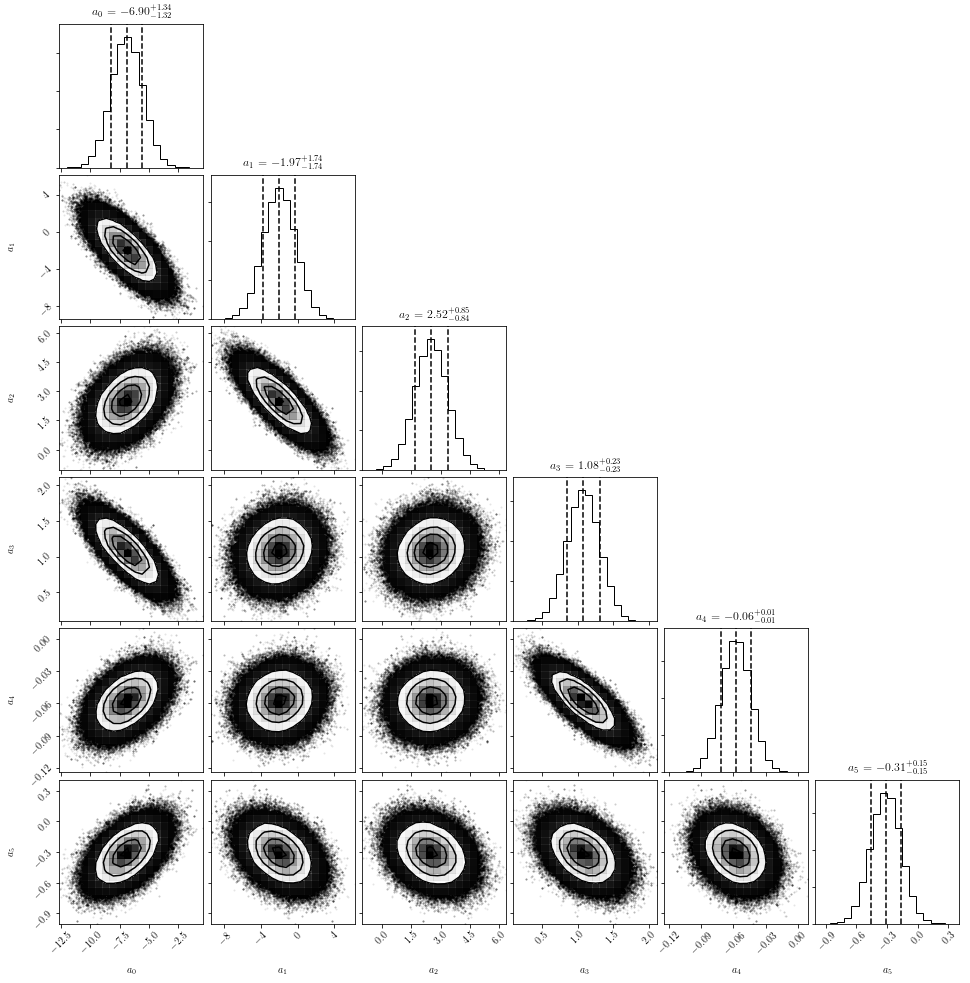

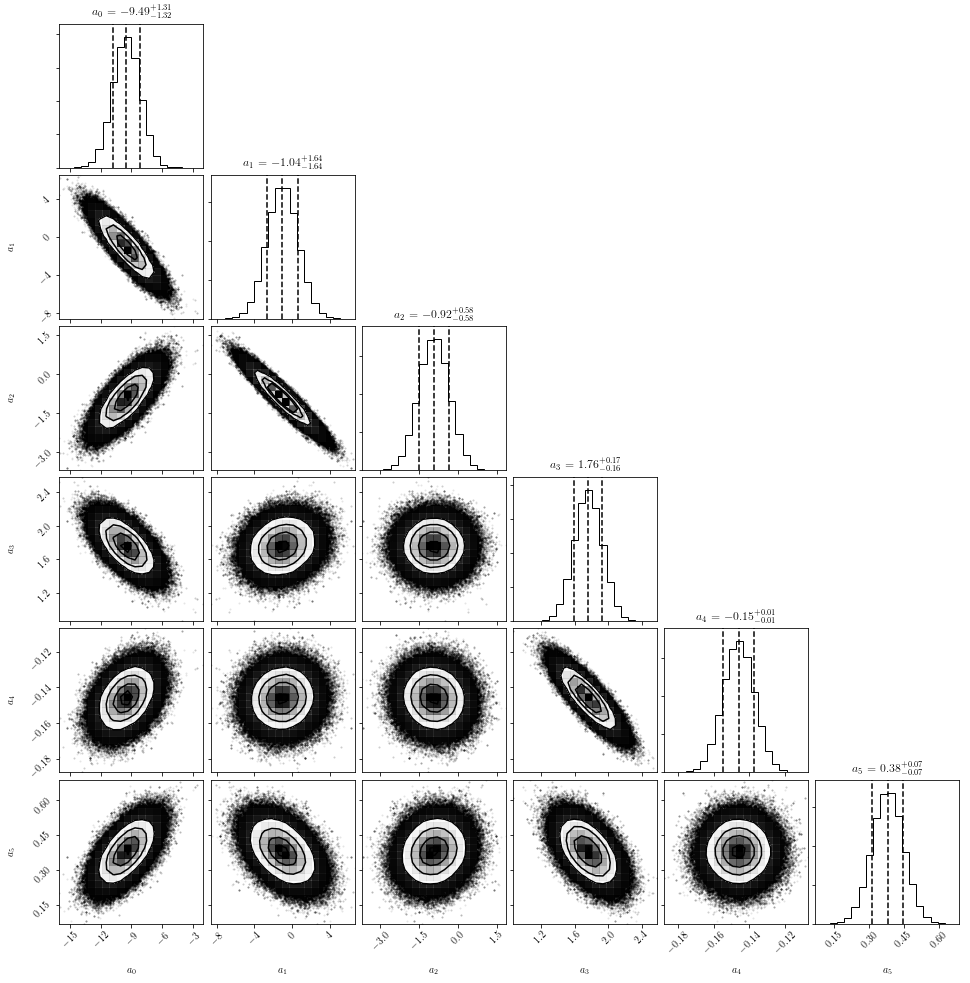

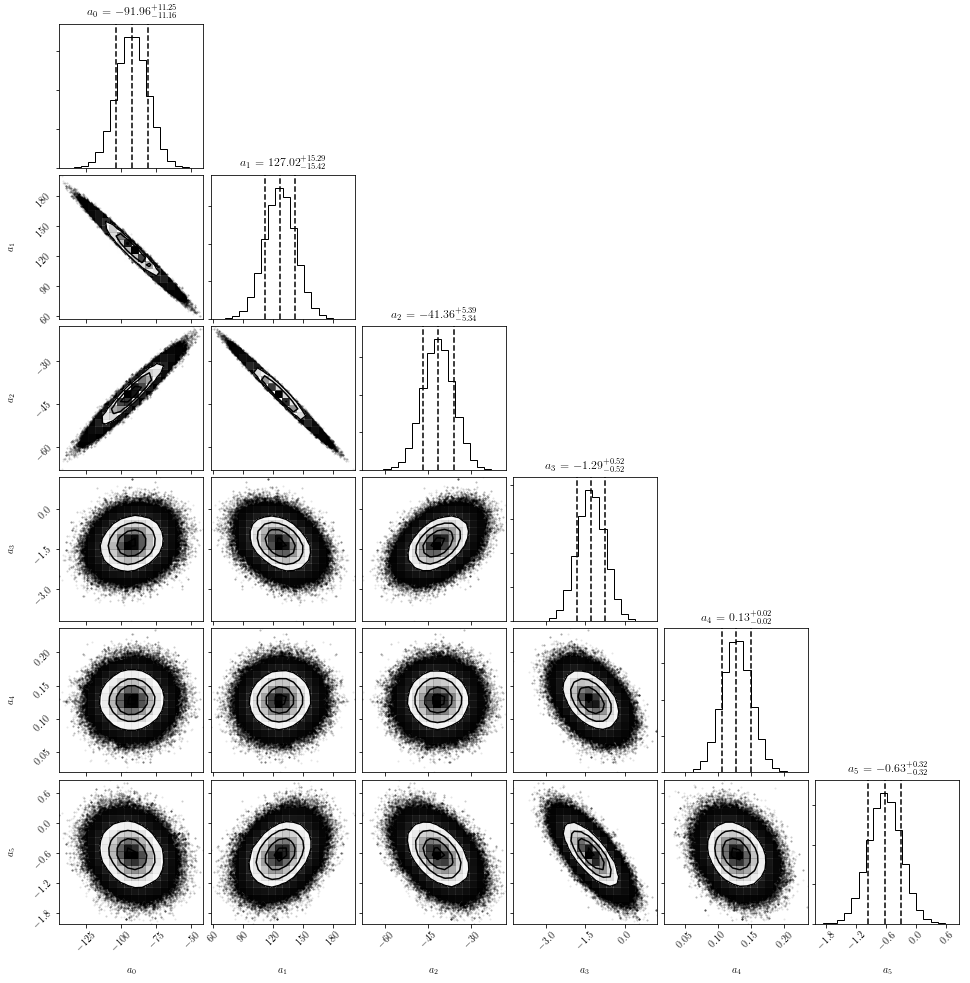

In [46]:
flat_samples1 = src.fit_relation_complex_func(mask_good * mask_color_1,g_rp,lage,log_lhalbol,log_lhalbol_error,
                                              name='corner_fit_color_1.png')
flat_samples2 = src.fit_relation_complex_func(mask_good * mask_color_2,g_rp,lage,log_lhalbol,log_lhalbol_error,
                                              name='corner_fit_color_2.png')
flat_samples3 = src.fit_relation_complex_func(mask_good * mask_color_3,g_rp,lage,log_lhalbol,log_lhalbol_error,
                                              name='corner_fit_color_3.png')

In [107]:
def west2008(x,a,b,n,l):
    lhalbol = np.ones(len(x))*np.nan
    mask = x < l
    lhalbol[mask] = a/(x[mask]**n-l**n) - b
    return lhalbol

In [108]:
def fit_halpha(params,z,x):

    a0,a1,a2,a3,a4,a5 = params

    
    halpha_model = (a0 + a1*z + a2*z**2 +
                    a3*x + a4*x**2 +
                    a5*z*x)


    return halpha_model
        

def lnlike_color_abs_age(params_x,g_rp_x,log10age_x,log10ewha_x,log10ewha_error_x):
    model_halpha = fit_halpha(params_x,g_rp_x,log10age_x)
    return -0.5*np.sum((model_halpha - log10ewha_x)**2/(log10ewha_error_x**2)) 


In [110]:
mask_nan_inf_color_1 = (~np.isnan(g_rp+lage+log_lhalbol+log_lhalbol_error) * mask_keep
                       * (log_lhalbol_error!=0) * mask_color_1 * (~mask_weird))

ini_params = np.ones(6)*0.1

nll = lambda *args: -lnlike_color_abs_age(*args)
res_all_color_1 = op.minimize(nll, ini_params, args=(g_rp[mask_nan_inf_color_1],lage[mask_nan_inf_color_1],
                                             log_lhalbol[mask_nan_inf_color_1],
                                             log_lhalbol_error[mask_nan_inf_color_1]))

ndim, nwalkers = len(res_all_color_1.x), 100

p0 = np.array([res_all_color_1.x+np.random.rand()*0.1 for i in range(nwalkers)])

sampler_color_1 = emcee.EnsembleSampler(nwalkers, ndim, lnlike_color_abs_age, args=[g_rp[mask_nan_inf_color_1],
                                                                                    lage[mask_nan_inf_color_1],
                                                                                    log_lhalbol[mask_nan_inf_color_1],
                                                                                    log_lhalbol_error[mask_nan_inf_color_1]])
sampler_color_1.run_mcmc(p0, 10000)

chain_color_1 = sampler_color_1.chain[:,500:,:]
flat_samples_color_1 = chain_color_1.reshape((-1,ndim))

<IPython.core.display.Javascript object>


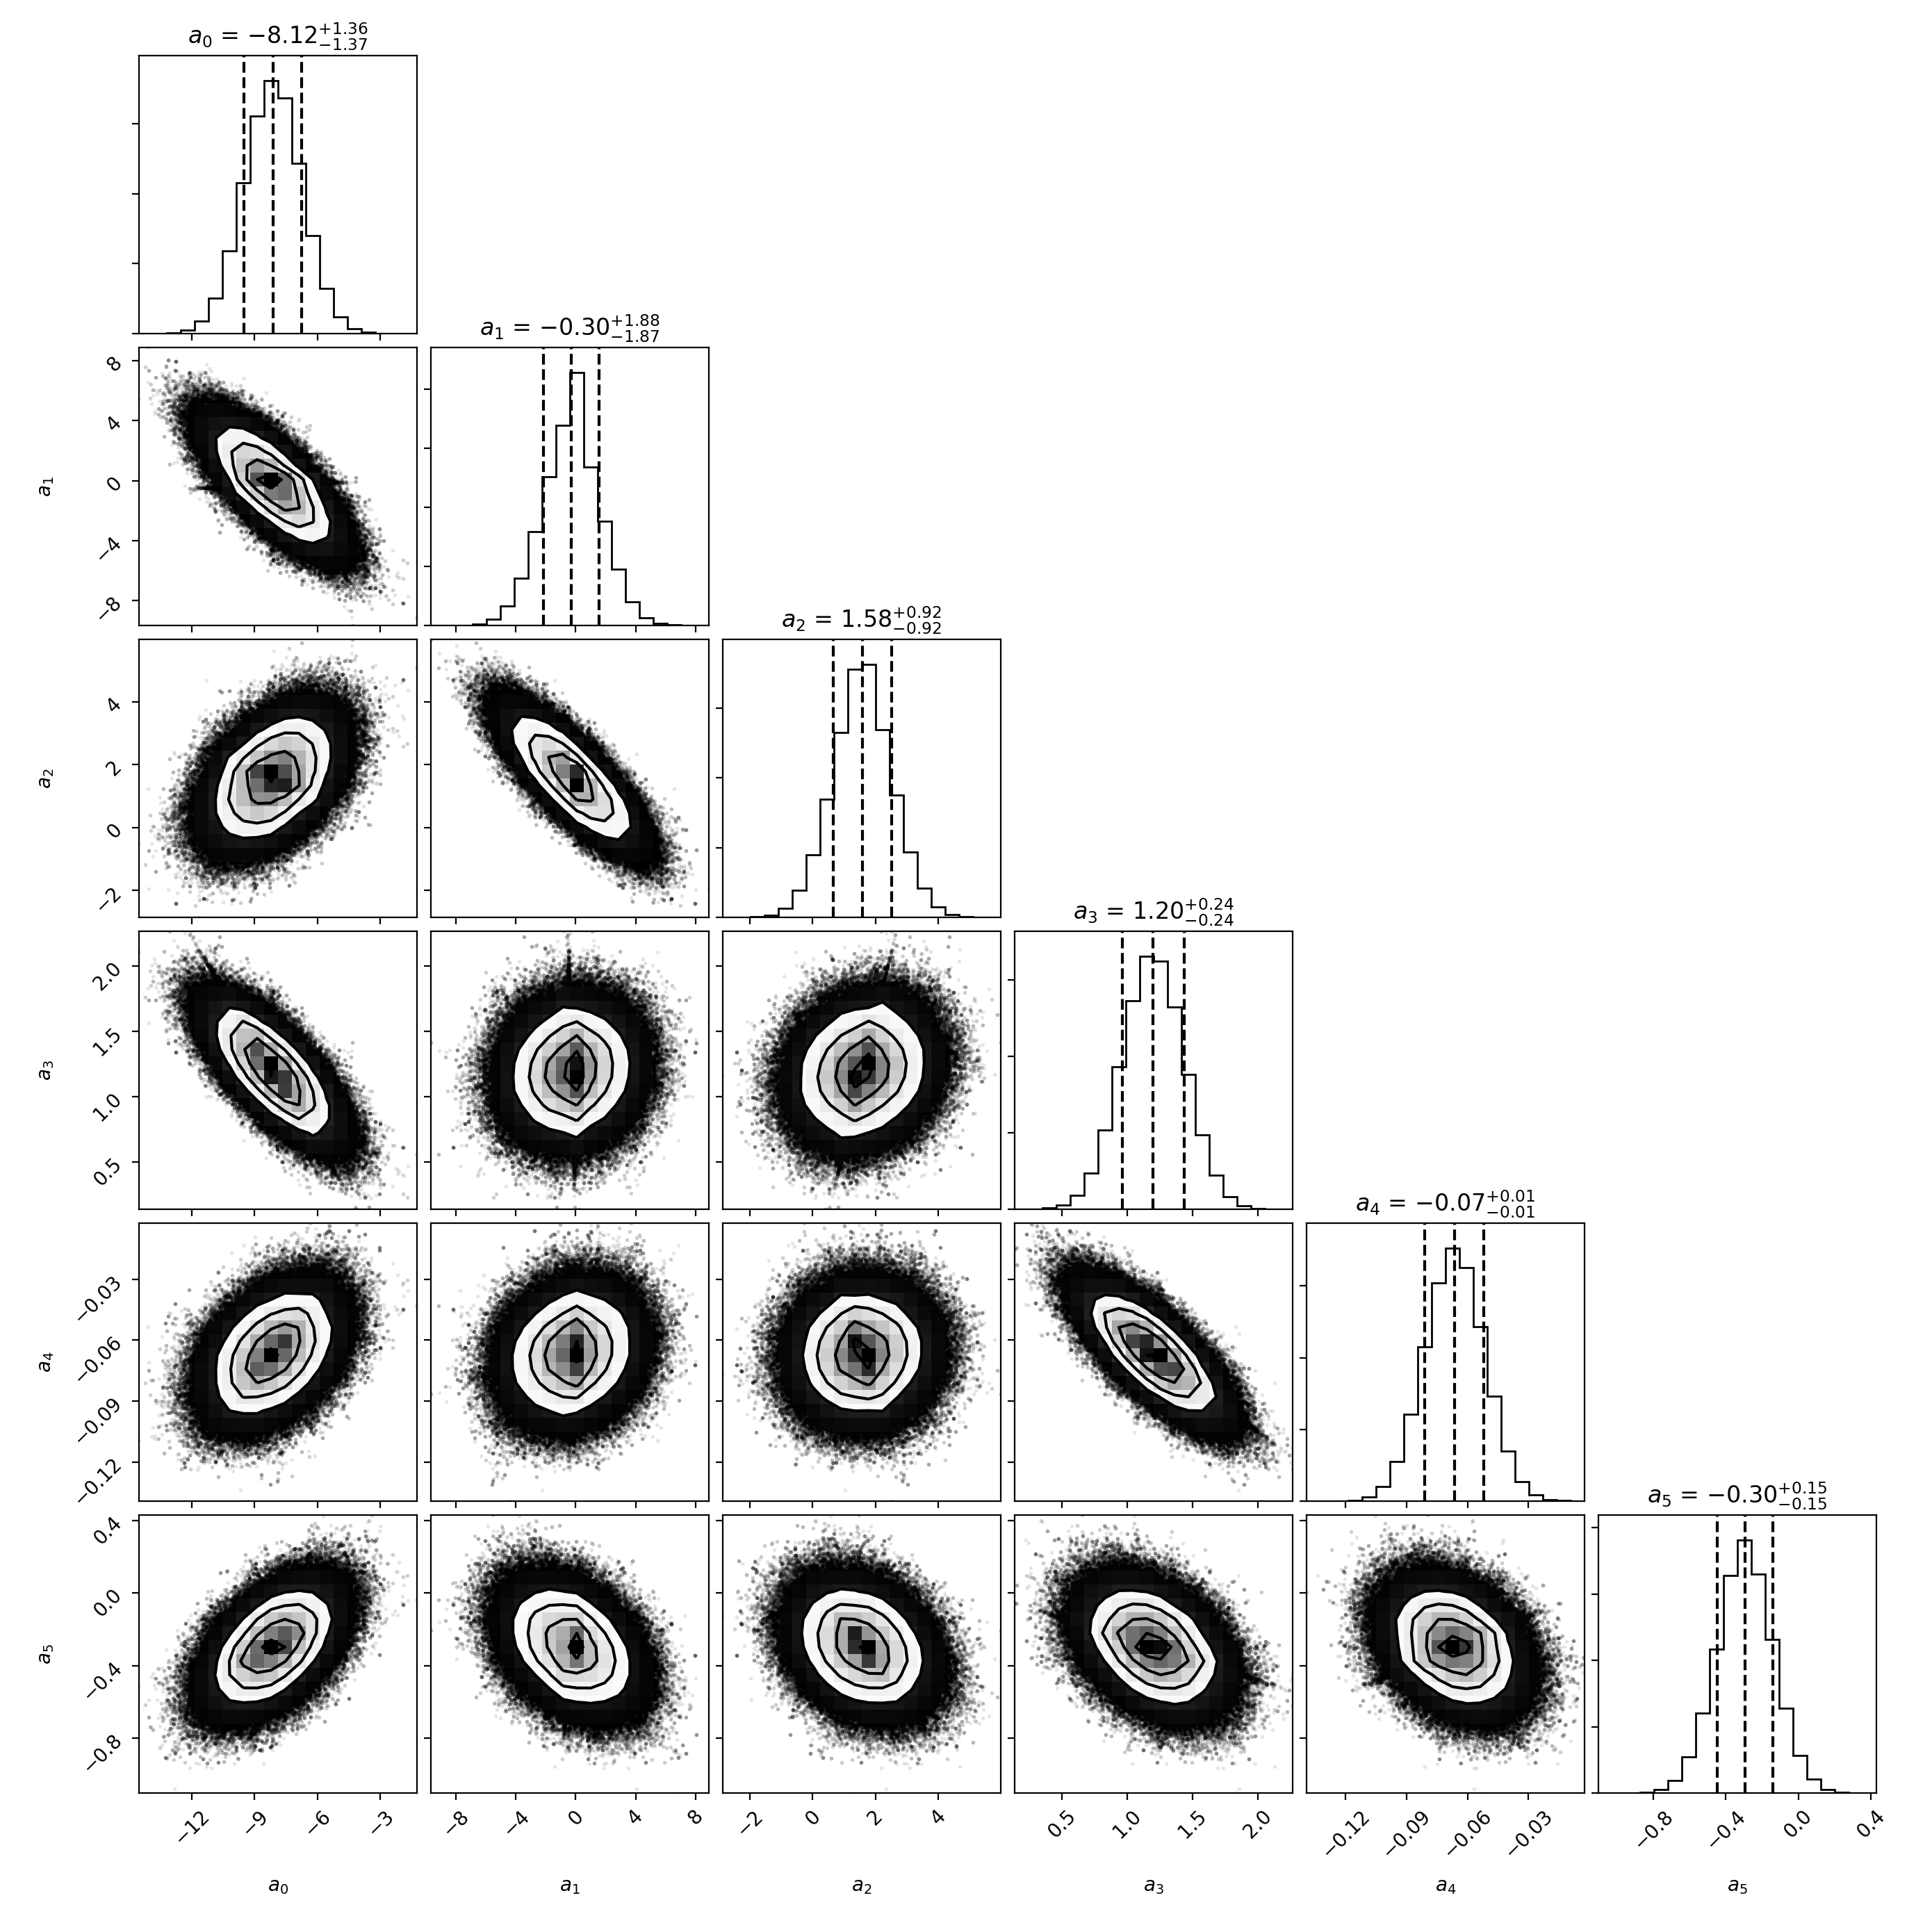

In [111]:
labels = ['$a_0$','$a_1$','$a_2$','$a_3$','$a_4$','$a_5$']

fig = corner.corner(flat_samples_color_1, labels=labels, quantiles=[.16,.50,.84], 
                    show_titles=True, title_kwargs={"fontsize": 12})
fig.savefig('/Users/rociokiman/Dropbox (Personal)/Apps/Overleaf/Age-Activity Relation for M dwarfs/corner_fit_color_1.png',dpi=300)

In [112]:
mask_nan_inf_color_2 = (~np.isnan(g_rp+lage+log_lhalbol+log_lhalbol_error) * mask_keep
                       * (log_lhalbol_error!=0) * mask_color_2  * (~mask_weird))

ini_params = np.ones(6)*0.1

nll = lambda *args: -lnlike_color_abs_age(*args)
res_all_color_2 = op.minimize(nll, ini_params, args=(g_rp[mask_nan_inf_color_2],lage[mask_nan_inf_color_2],
                                             log_lhalbol[mask_nan_inf_color_2],
                                             log_lhalbol_error[mask_nan_inf_color_2]))

ndim, nwalkers = len(res_all_color_2.x), 100

p0 = np.array([res_all_color_2.x+np.random.rand()*0.1 for i in range(nwalkers)])

sampler_color_2 = emcee.EnsembleSampler(nwalkers, ndim, lnlike_color_abs_age, args=[g_rp[mask_nan_inf_color_2],
                                                                                    lage[mask_nan_inf_color_2],
                                                                                    log_lhalbol[mask_nan_inf_color_2],
                                                                                    log_lhalbol_error[mask_nan_inf_color_2]])
sampler_color_2.run_mcmc(p0, 10000)

chain_color_2 = sampler_color_2.chain[:,500:,:]
flat_samples_color_2 = chain_color_2.reshape((-1,ndim))

<IPython.core.display.Javascript object>


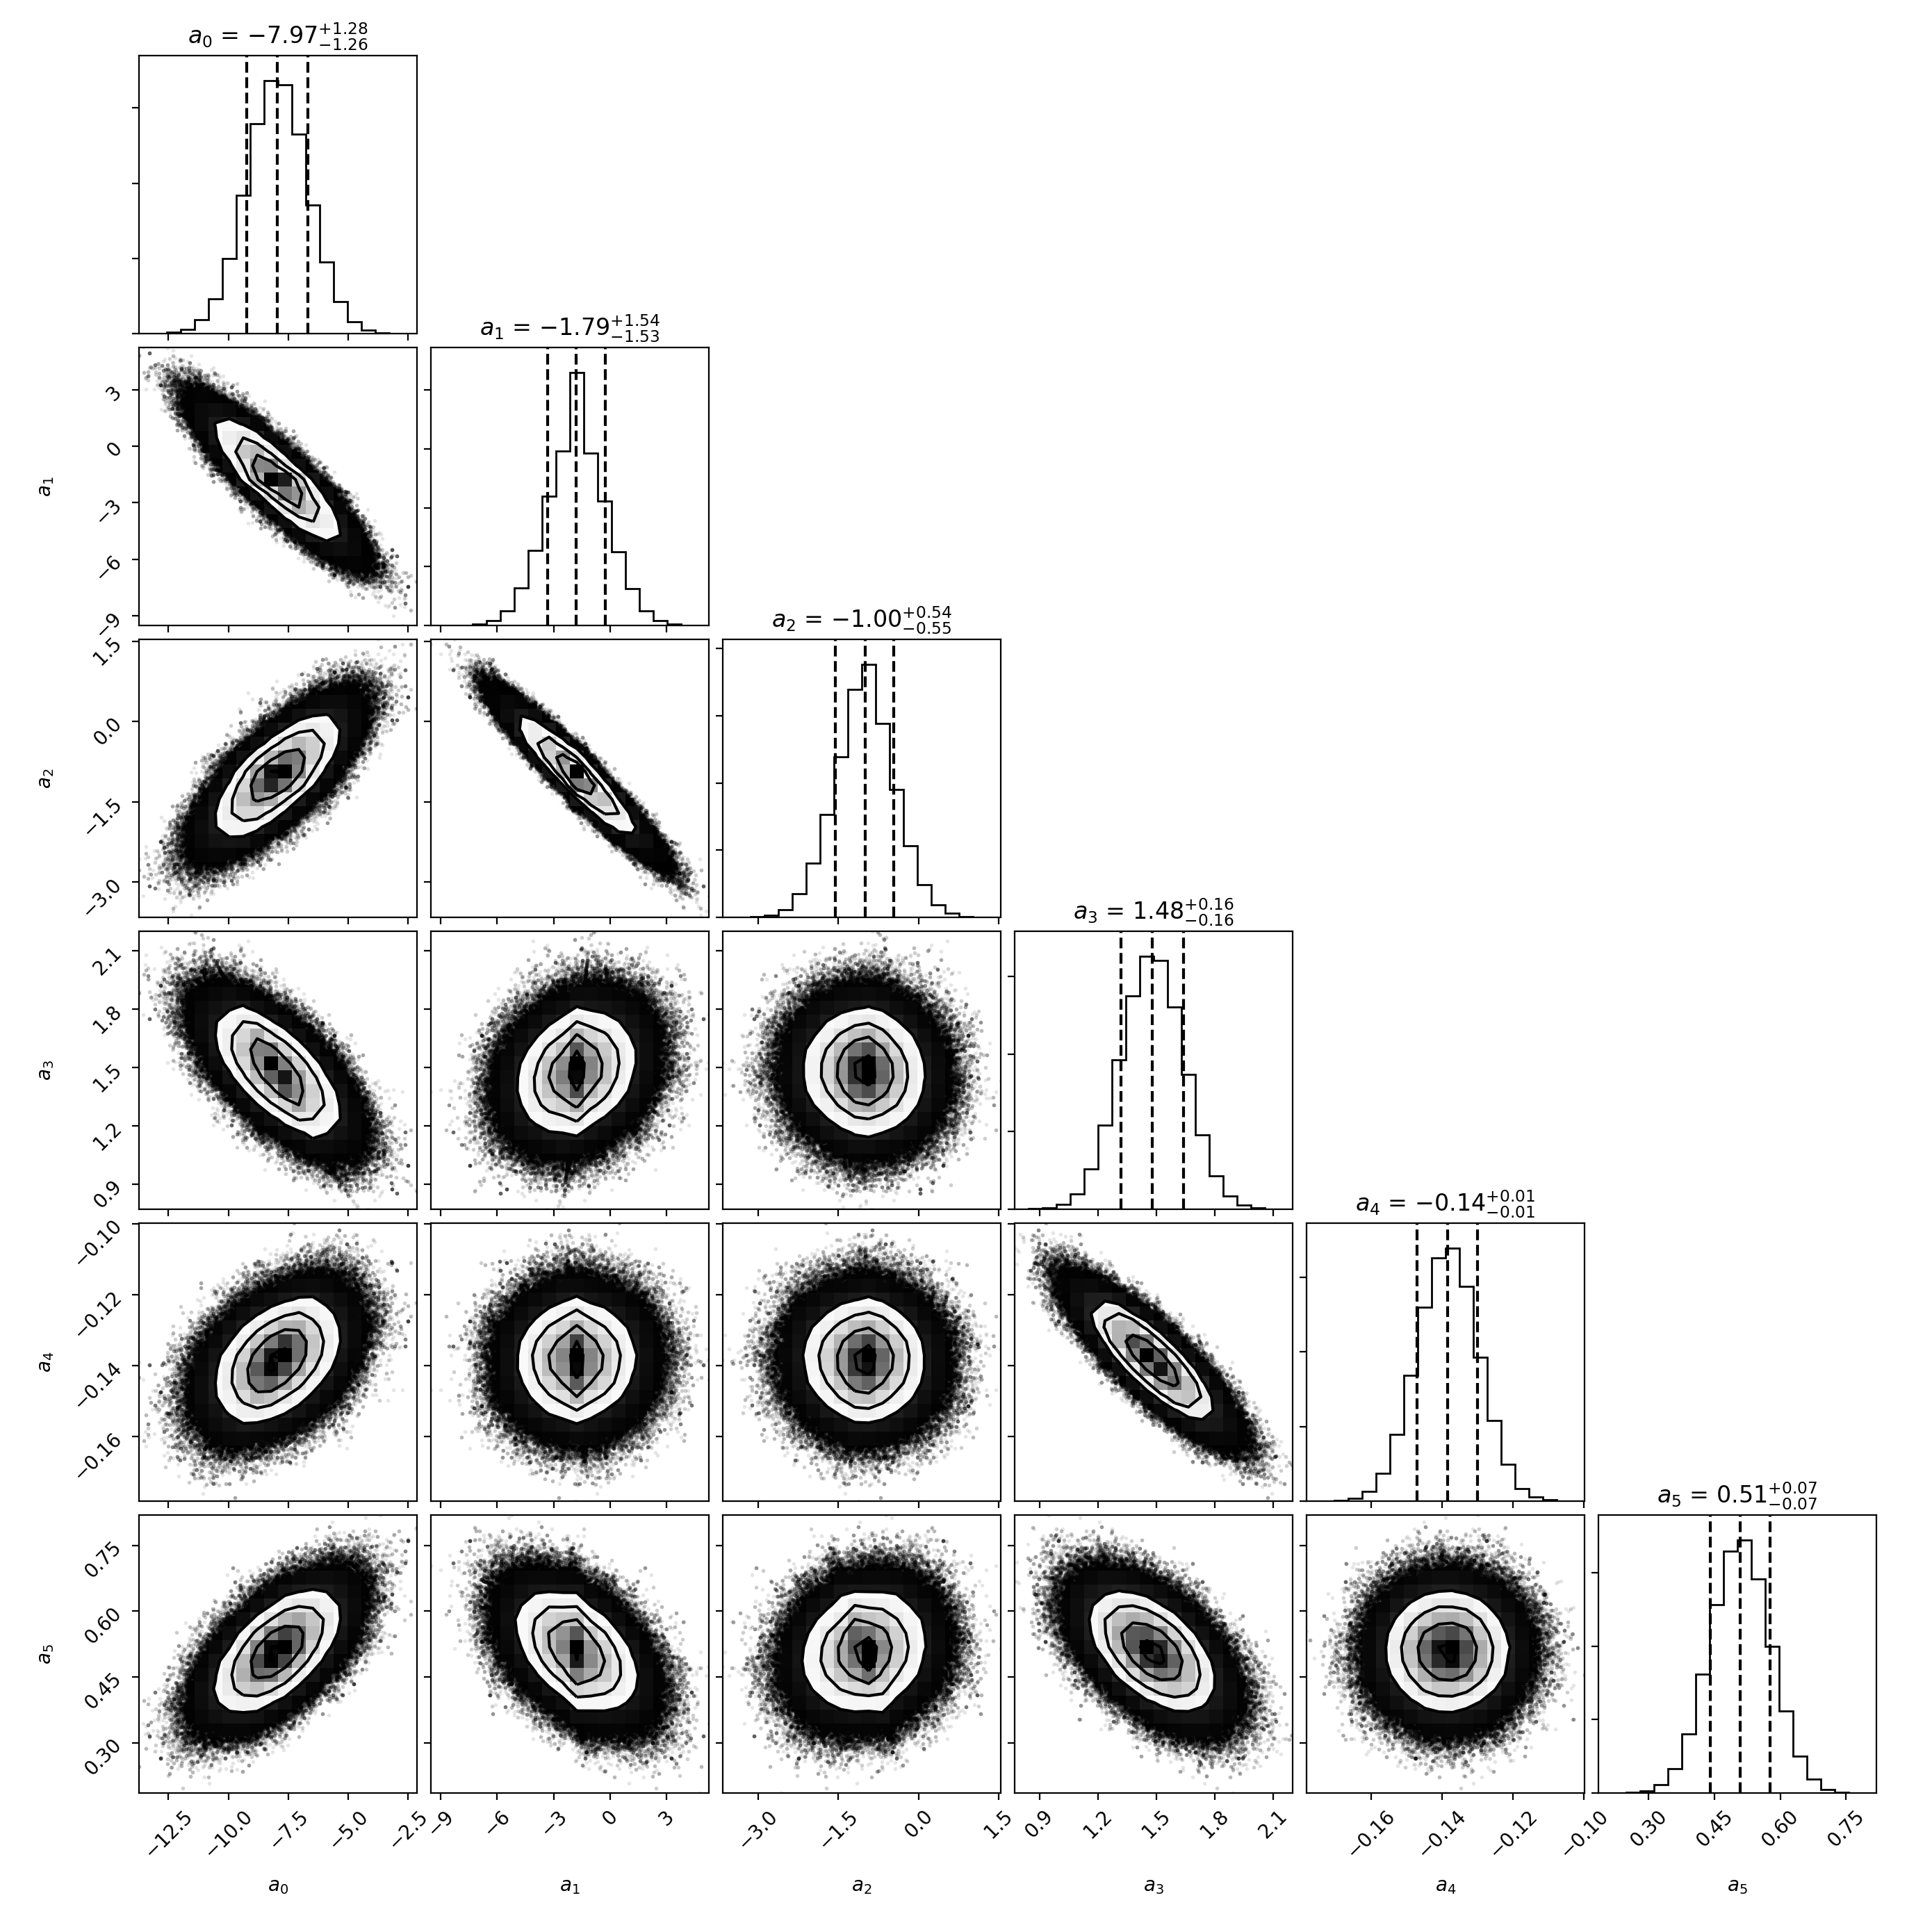

In [113]:
labels = ['$a_0$','$a_1$','$a_2$','$a_3$','$a_4$','$a_5$']

fig = corner.corner(flat_samples_color_2, labels=labels, quantiles=[.16,.50,.84], 
                    show_titles=True, title_kwargs={"fontsize": 12})
fig.savefig('/Users/rociokiman/Dropbox (Personal)/Apps/Overleaf/Age-Activity Relation for M dwarfs/corner_fit_color_2.png',dpi=300)

In [114]:
mask_nan_inf_color_3 = (~np.isnan(g_rp+lage+log_lhalbol+log_lhalbol_error) * mask_keep
                       * (log_lhalbol_error!=0) * mask_color_3  * (~mask_weird))

ini_params = np.ones(6)*0.1

nll = lambda *args: -lnlike_color_abs_age(*args)
res_all_color_3 = op.minimize(nll, ini_params, args=(g_rp[mask_nan_inf_color_3],lage[mask_nan_inf_color_3],
                                             log_lhalbol[mask_nan_inf_color_3],
                                             log_lhalbol_error[mask_nan_inf_color_3]))

ndim, nwalkers = len(res_all_color_3.x), 100

p0 = np.array([res_all_color_3.x+np.random.rand()*0.1 for i in range(nwalkers)])

sampler_color_3 = emcee.EnsembleSampler(nwalkers, ndim, lnlike_color_abs_age, args=[g_rp[mask_nan_inf_color_3],
                                                                                    lage[mask_nan_inf_color_3],
                                                                                    log_lhalbol[mask_nan_inf_color_3],
                                                                                    log_lhalbol_error[mask_nan_inf_color_3]])
sampler_color_3.run_mcmc(p0, 10000)

chain_color_3 = sampler_color_3.chain[:,500:,:]
flat_samples_color_3 = chain_color_3.reshape((-1,ndim))

<IPython.core.display.Javascript object>


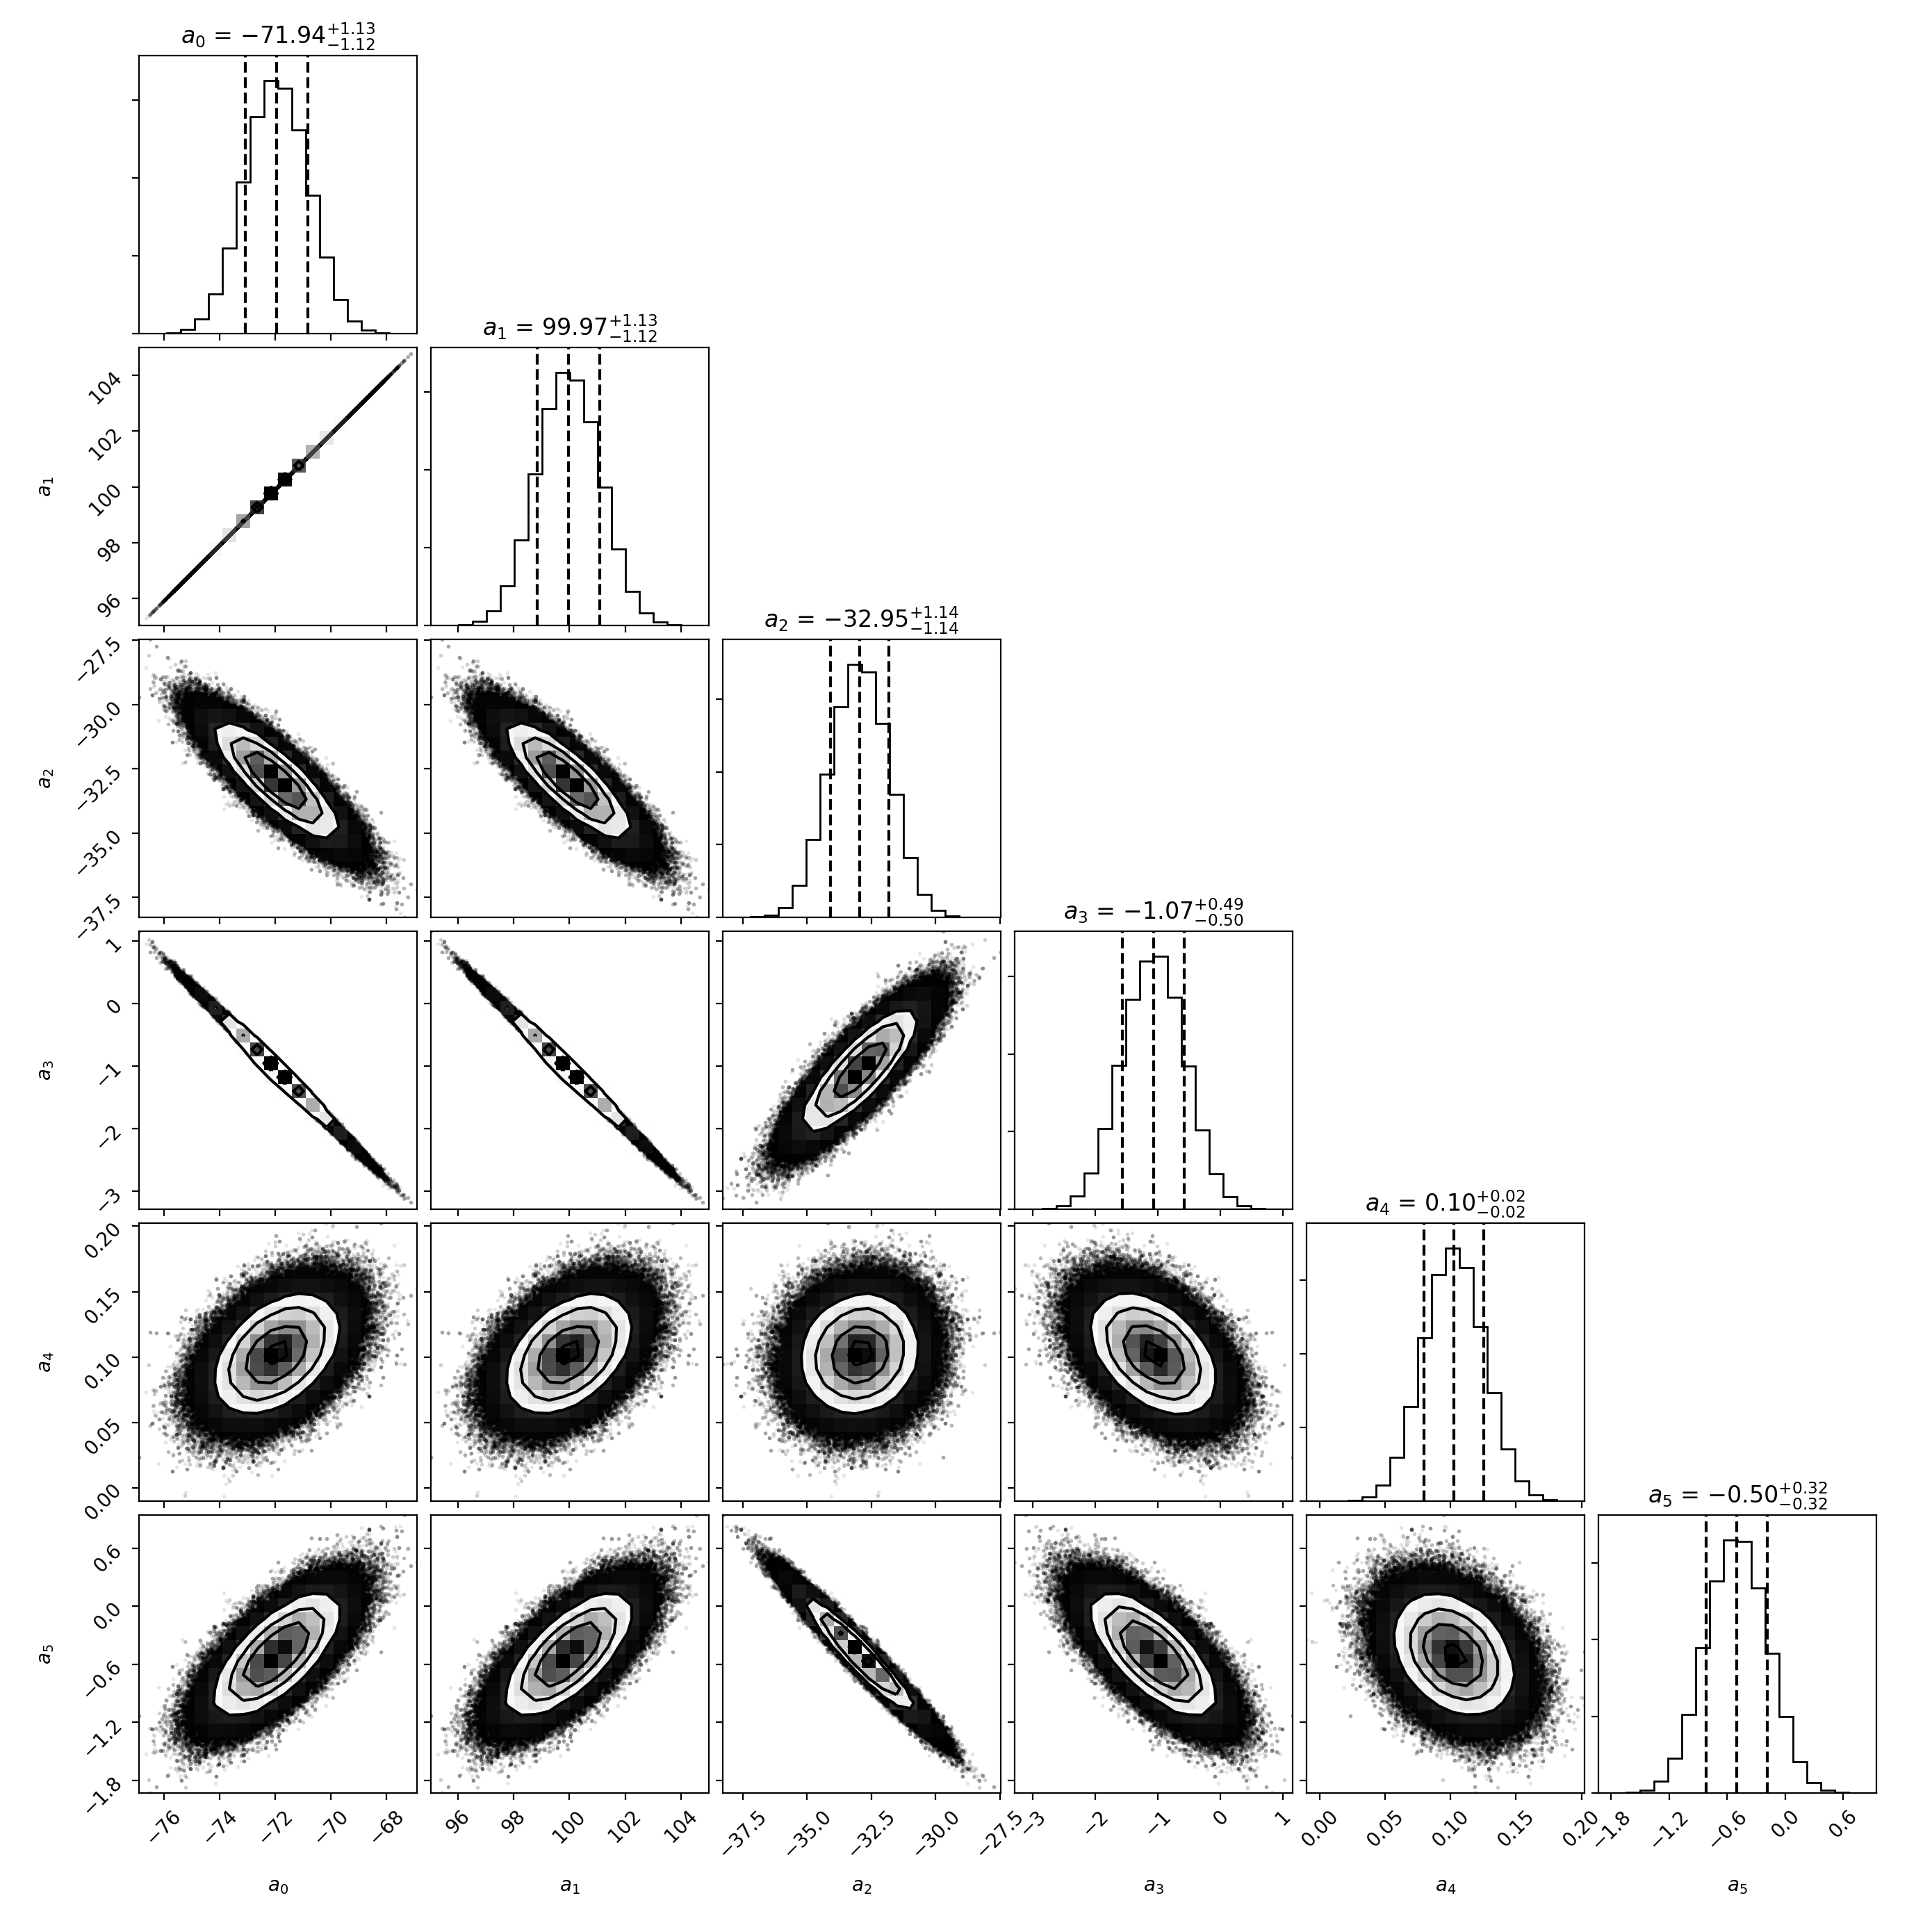

In [115]:
labels = ['$a_0$','$a_1$','$a_2$','$a_3$','$a_4$','$a_5$']

fig = corner.corner(flat_samples_color_3, labels=labels, quantiles=[.16,.50,.84], 
                    show_titles=True, title_kwargs={"fontsize": 12})
fig.savefig('/Users/rociokiman/Dropbox (Personal)/Apps/Overleaf/Age-Activity Relation for M dwarfs/corner_fit_color_3.png',dpi=300)